In [1]:
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Exploration of Detroit traffic crashes
Jonathan Folstein<br>
02/2020<br>
<br>
<br>

<font size="4" />This notebook, coded  during February 2020, documents my exploration of a public data set containing data about car crashes in Detroit between 2011 and 2016; the database has 148272 cases and 40 features. The analyses were performed on a System76 pc with 16 cores running Ubuntu 18.x. My overall goal was to demonstrate basic knowledge of machine learning and python by diving in and trying to fit a dataset that hasn't been hand-picked for a data science course.</font>

<font size="4" />The database is called Traffic Crashes and can be downloaded from the City of Detroit Open Data Portal at data.detroitmi.gov/datasets/traffic-crashes. It includes a number of different features about each crash, including time of day, year, road conditions, etc.  Because it includes a feature for number of fatalities (zero the vast majority of the time), I decided to make it a classification problem and try to predict which crashes are fatal (i.e. fatalities > 0). One of the things that made this task interesting was that the data were highly skewed, with a very small percentage of the crashes having any fatalities. Another distinctive feature of the data was that, although the fatal crashes form fairly distinct clusters in the space, they are completely intermixed with non-fatal cases even at their most dense. 

<font size="4" />In this toy example, one could imagine a warning system for a car. One possibility is a binary (on/off) light that turned on to alert the driver that they were in a particularly dangerous situation and should exercise caution. Such a system should have high recall because the idea is to alert the driver to be cautious rather than have a red altert indicating that an accident is actually about to happen - thus, the driver would assume a very high false positive rate, but would want the system to accurately flag dangerous situations, i.e. have a low false negative rate. 

<font size="4" />One way to evaluate such a system is to find a probability threshold low enough for recall to be high, but not so low that accuracy plumets. The exact threshold one should choose for this seemed to me to be a subjective decision, but I decided on evaluate the model on recall when accuracy was around 90%. 
    
<font size="4" />Another possible warning system would not be binary, but rather give a continuous estimate of danger. For instance, it might be a light that varied continuously from green to red, depending on the probability of a crash. A continuous system like this should be evaluated differently. We should evaluate its ability to accurately estimate the probability of each instance. Area under the ROC curve would capture this, but, because the data set is skewed, area under the precision-recall curve is better.
    
<font size="4" />One final consideration is what measure to optimize when choosing hyperparameters of the models. For our binary system, we want the parameters that give the best recall for 90% accuracy. I don't know of a way to conveniently optimize exactly this, so I took the approach of first optimizing on a metric and then finding the desired threshold. In the explorations below, I tried two metrics: recall and "average precision", which is a metric recommended for optimizing the precision-recall curve. Average precision = $$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$$ where R is recall, P is precision, and n is the probability threshold.
    
<font size="4" />Finally, I performed grid searches using these metrics on three classifiers: logistic regression, SVM with rbf kernel, and gradient boosted decision tree (scikit learn's GradientBoostingClassifier). The following code is annotated with Markdown cells commenting on each step in the fitting process. 
    
(One final note: most of the functions I wrote for this ct are in the file ctfunctions.ipynb)

In [2]:
%matplotlib inline
from typing import Any

In [3]:
import pandas as pd
import numpy as np
import time
from math import cos, sin, pi, radians
import matplotlib.pyplot as plt
import warnings
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
from joblib import dump, load
from functools import wraps

# Project functions

<font size="4" />The cell below contains the functions for the project. 

In [4]:
def get_pred_4thresh(threshold,classifier,probs):
    
    pred = np.zeros(len(probs))
    pred[probs[:,1]>=threshold]=1
    
    return pred

def dumpandloadclf(action,clf,filename):

    if action=='dump':
        dump(clf,f"{filename}.joblib")
    elif action =='load':
        newclf=load(filename)
        return newclf


def listthekeys(func):
    @wraps(func)
    def wrapper(*args,**kwargs):
        result = func(*args,**kwargs)
        if len(result)==0:
            print("Didn't get any classifiers. The string you provide will load string *.joblib")
        print(f'dictionary has these classifiers: {list(result.keys())}')
        return result
    return wrapper



#@listthekeys
def loadsomeclfs(textstem):

    from glob import glob
    filelist = glob(f"{textstem}*.joblib")
    clsdict = {}
    for file in filelist:
        clname = []
        for let in file:
            if let == ".":
                break
            clname.append(let)
        clname = ''.join(clname)
        clsdict[clname] = dumpandloadclf('load',[],file)
    return clsdict


def plotrocs(xdata,ydata,precthresh,*args):
    clsdict = loadsomeclfs("")
    fig,axs = plt.subplots(1,2)
    for mycls in args:
        y_score = clsdict[mycls].decision_function(xdata)
        fpr,tpr,_=roc_curve(ydata,y_score)
        prec,rec,_=precision_recall_curve(ydata,y_score)

        axs[0].plot(fpr,tpr,label=mycls)
        axs[1].plot(rec,prec,label=mycls)
    
    axs[0].legend(loc='lower right')
    axs[0].set(ylabel='true positive rate')
    axs[0].set(xlabel='false positive rate')
    axs[0].set(title='ROC curve')
    
    axs[1].legend(loc='upper right')
    axs[1].set(ylabel='precision')
    axs[1].set(xlabel='recall')
    axs[1].set(title='precision-recall curve')
    axs[1].set_ylim(precthresh,1)
    axs[1].set_xlim(0,1-precthresh)
    
    fig.subplots_adjust( hspace=.5,
                    wspace=.5)
    
    fig.set_figheight(10)
    fig.set_figwidth(20)
    
    clsdict.clear()
  
    
    
def summarize_threshold_scores(clfname,inputdict,thresholds,xtrain,ytrain,xtest,ytest):

    clfdict = loadsomeclfs("")
    clf = clfdict[clfname]
    clfdict.clear()
    probs_tr=clf.predict_proba(xtrain) 
    probs_test=clf.predict_proba(xtest)
    
    thresh_ind = 0

    for t in thresholds:
        
        pred_tr = get_pred_4thresh(t,clf,probs_tr)
        pred_test = get_pred_4thresh(t,clf,probs_test)


        temp = inputdict.copy()


        for sci in inputdict.keys():
            for seti in inputdict[sci]['datasets']:

                if seti == 'training':
                    inputdict[sci]['datasets'][seti][thresh_ind] = inputdict[sci]['scoretype'](ytrain,pred_tr)

                else:
                    inputdict[sci]['datasets'][seti][thresh_ind] = inputdict[sci]['scoretype'](ytest,pred_test)

        thresh_ind += 1

    for seti in ['training','test']:

        plt.title("Precision-recall vs Threshold: %s set" % seti)
        plt.plot(thresholds, inputdict['prec']['datasets'][seti], "b-o", label="Precision")
        plt.plot(thresholds,inputdict['rec']['datasets'][seti], "r-o", label="recall")
        plt.plot(thresholds,inputdict['f1']['datasets'][seti], "g-o", label="F1")
        plt.plot(thresholds,inputdict['ac']['datasets'][seti], "c-o", label="AC")
        plt.ylabel("Score")
        plt.xlabel("Threshold")
        plt.legend(loc="upper right")
        plt.ylim([0,1])
        plt.show()
    
    
    print("Scores for the test set:")
    print()
    print("precision  recall   ac    f1    threshold  ")

    for av_prec_testp,av_rec_testp,av_ac_testp,av_f1_testp, threshp in zip(inputdict['prec']['datasets']['test'],
                                                                           inputdict['rec']['datasets']['test'],
                                                                           inputdict['ac']['datasets']['test'],
                                                                           inputdict['f1']['datasets']['test'],
                                                                           thresholds):

        print("%0.3f      %0.3f  %0.3f   %0.3f   %0.3f  "
              % (av_prec_testp,av_rec_testp,av_ac_testp,av_f1_testp, threshp))


def prep4sorting(xdata, ydata, clfnames, clsdict):
    pca = PCA(n_components=10)
    xpca = pca.fit_transform(xdata)
    xpca_df = pd.DataFrame(xpca)
    xpca_df['y'] = ydata.values

    for myclf in clfnames:
        probs = clsdict[myclf].predict_proba(xdata)
        xpca_df[f"probs_{myclf}"] = probs[:, 1]

    return xpca_df


def getsomesorteddfs(*clfnames):
    clsdict = loadsomeclfs("")
    xtrain, xtest, ytrain, ytest = loadprocessdata()
    xtrain_pca_probs = prep4sorting(xtrain, ytrain, clfnames, clsdict)
    xtest_pca_probs = prep4sorting(xtest, ytest, clfnames, clsdict)
    sortdict = {}
    for myclf in clfnames:
        sortdict.update({myclf: {'test_sorted': xtest_pca_probs.sort_values(by=f"probs_{myclf}"),
                                 'train_sorted': xtrain_pca_probs.sort_values(by=f"probs_{myclf}")}})

    clsdict.clear()
    return sortdict


def plotpca_subs23c(classifiername, plotsize,mycomps):

    def mksubplot(axvar,position1,position2,cases,titlevars,nscatters=False):
        
        xdat = cases[mycomps[0]]
        ydat = cases[mycomps[1]]
        colordat = cases['probs_{}'.format(classifiername)]
        
        sc=axs[position1,position2].scatter(xdat,ydat,s=plotsize,c=colordat,cmap=cm.YlOrRd, vmin = colormin, vmax = colormax )
        axvar[position1,position2].set(xlabel = 'PC {}'.format(mycomps[0]))
        axvar[position1,position2].set(ylabel = 'PC {}'.format(mycomps[1]))
        axvar[position1,position2].set_xlim(xlim_train)
        axvar[position1,position2].set_ylim(ylim_train)
        axvar[position1,position2].set(title='{} set:\n {} accidents {}'.format(titlevars[0],titlevars[1],classifiername))
        fig.colorbar(sc,ax=axvar[position1,position2])
        
        return axvar
        
    sorted_sets = getsomesorteddfs(classifiername)
    traindf, testdf = sorted_sets[classifiername]['train_sorted'], sorted_sets[classifiername]['test_sorted']
    xlim_train = [np.min(traindf[mycomps[0]]),np.max(traindf[mycomps[0]])]
    ylim_train = [np.min(traindf[mycomps[1]]),np.max(traindf[mycomps[1]])]
    
    xlim_test = [np.min(testdf[mycomps[0]]),np.max(testdf[mycomps[0]])]
    ylim_test = [np.min(testdf[mycomps[1]]),np.max(testdf[mycomps[1]])]
    
    colormax = 1;
    colormin = 0;
    
    fig, axs = plt.subplots(2,4)

    params ={'datatypes2':['train','test'], 'datatypes': ['training', 'test'],'ydata': [traindf['y'], testdf['y']],'xdata': [traindf,testdf], 'traincodes':[0,1],
             'casetypes': ['non-fatal','fatal','all'], 'casecodes': np.array([0,1])}
    
    for traini in range(2):
        for casei in range(3):
            data = params['xdata'][traini]
            
            if casei == 2:
                
                cases2plot = data
                
            else:
                
                dataind = params['ydata'][traini]==params['casecodes'][casei]
                cases2plot = data[dataind]
            
            titlevars =[params['datatypes'][traini], params['casetypes'][casei]]
            
            axs = mksubplot(axs,traini,casei,cases2plot,titlevars)

    dataind = params['ydata'][0] == 0
    nonfataltrn = traindf[dataind]
    dataind = params['ydata'][0] == 1
    fataltrn = traindf[dataind]
    dataind = params['ydata'][1] == 0
    nonfataltst = testdf[dataind]
    dataind = params['ydata'][1] == 1
    fataltst = testdf[dataind]

    axs[0,3].hist(nonfataltrn[f"probs_{classifiername}"], bins=25,range=[.001,1],edgecolor='black',color='blue',label='non-fatal')
    axs[0,3].hist(fataltrn[f"probs_{classifiername}"], bins=25,range=[.001,1],edgecolor='black',color='red',label='fatal')
    axs[0,3].set_ylim(ymin=0,ymax=150)
    axs[0,3].set_xlabel("probability")
    axs[0,3].set_ylabel("frequency")
    axs[1,3].hist(nonfataltst[f"probs_{classifiername}"], bins=25,range=[.001,1],edgecolor='black',color='blue',label='non-fatal')
    axs[1,3].hist(fataltst[f"probs_{classifiername}"], bins=25,range=[.001,1],edgecolor='black',color='red',label='fatal')
    axs[1,3].set_ylim(ymin=0,ymax=150)
    axs[1,3].set_xlabel("probability")
    axs[1,3].set_ylabel("frequency")

#     axs[0, 4].hist(nonfataltrn[f"probs_{classifiername}"], bins=50, range=[.0001, .08], edgecolor='black', color='blue',label='non-fatal')
#     axs[0, 4].hist(fataltrn[f"probs_{classifiername}"], bins=50, range=[.0001, .08], color='red',label='fatal')
#     axs[0, 4].set_ylim(ymin=0, ymax=8000)
#     axs[0, 4].set_xlabel("probability")
#     axs[0, 4].set_ylabel("frequency")
#     axs[1, 4].hist(nonfataltst[f"probs_{classifiername}"], bins=50, range=[.0001, .08], edgecolor='black', color='blue',label='non-fatal')
#     axs[1, 4].hist(fataltst[f"probs_{classifiername}"], bins=50, range=[.0001, .08], color='red',label='fatal')
#     axs[1, 4].set_ylim(ymin=0, ymax=8000)
#     axs[1, 4].set_xlabel("probability")
#     axs[1, 4].set_ylabel("frequency")

    fig.subplots_adjust( hspace=.5,
                    wspace=.5)
    
    fig.set_figheight(10)
    fig.set_figwidth(20)
    
    
    
    
def plotpca_subs23b(traindf, testdf, classifiername, plotsize,mycomps,subpltdim1,subpltdim2):
    
    def mksubplot(axvar,position1,position2,cases,titlevars,nscatters=False):
        
        xdat = cases[mycomps[0]]
        ydat = cases[mycomps[1]]
        colordat = cases['probs_{}_{}'.format(params['datatypes2'][traini],classifiername)]
        
        sc=axs[position1,position2].scatter(xdat,ydat,s=plotsize,c=colordat,cmap=cm.YlOrRd, vmin = colormin, vmax = colormax )
        axvar[position1,position2].set(xlabel = 'PC {}'.format(mycomps[0]))
        axvar[position1,position2].set(ylabel = 'PC {}'.format(mycomps[1]))
        axvar[position1,position2].set_xlim(xlim_train)
        axvar[position1,position2].set_ylim(ylim_train)
        axvar[position1,position2].set(title='{} set probabilities for {} accidents {}'.format(titlevars[0],titlevars[1],classifiername))
        fig.colorbar(sc,ax=axvar[position1,position2])
        
        return axvar
        
    
    xlim_train = [np.min(traindf[mycomps[0]]),np.max(traindf[mycomps[0]])]
    ylim_train = [np.min(traindf[mycomps[1]]),np.max(traindf[mycomps[1]])]
    
    xlim_test = [np.min(testdf[mycomps[0]]),np.max(testdf[mycomps[0]])]
    ylim_test = [np.min(testdf[mycomps[1]]),np.max(testdf[mycomps[1]])]
    
    colormax = 1;
    colormin = 0;
    
    fig, axs = plt.subplots(subpltdim1,subpltdim2)

    params ={'datatypes2':['train','test'], 'datatypes': ['training', 'test'],'ydata': [traindf['y_train'], testdf['y_test']],'xdata': [traindf,testdf], 'traincodes':[0,1],
             'casetypes': ['non-fatal','fatal','all'], 'casecodes': np.array([0,1])}
    
    for traini in range(2):
        for casei in range(3):
            data = params['xdata'][traini]
            
            if casei == 2:
                
                cases2plot = data
                
            else:
                
                dataind = params['ydata'][traini]==params['casecodes'][casei]
                cases2plot = data[dataind]
            
            titlevars =[params['datatypes'][traini], params['casetypes'][casei]]
            
            axs = mksubplot(axs,traini,casei,cases2plot,titlevars)
   
    
    fig.subplots_adjust( hspace=.5,
                    wspace=.5)
    
    fig.set_figheight(10)
    fig.set_figwidth(20)



def point_on_circle(angle):
    '''
        Finding the x,y coordinates on circle, based on given angle
    '''
    from math import cos, sin, pi
    #center of circle, angle in degree and radius of circle
    center = [0,0]
    radius = 1
    x = center[0] + (radius * cos(angle))
    y = center[1] + (radius * sin(angle))

    return x,y


def summarize_gridsearch(clfname, xtest,ytest):

    clfdict = loadsomeclfs("")
    fit_classifier = clfdict[clfname]
    clfdict.clear()
    print("Best parameters set found on development set:")
    print()
    print(fit_classifier.best_params_)
    print()
    print("Grid scores on development set (validation):")
    print()
    means = fit_classifier.cv_results_['mean_test_score']
    stds = fit_classifier.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, fit_classifier.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
    if 'mean_train_score' in fit_classifier.cv_results_:
        print("Grid scores on development set (train):")
        print()
        means = fit_classifier.cv_results_['mean_train_score']
        stds = fit_classifier.cv_results_['std_train_score']
        for mean, std, params in zip(means, stds, fit_classifier.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
    else:
        print()
        print()
        print('No training score is in there.')
        print()

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, fit_classifier.predict(xtest)
    print(classification_report(y_true, y_pred))
    print()



def time_to_circlexy(time,timetype):
    '''
    convert hour of day, or month of year to coordinates on a circle, 
    allowing similar times to be similar features
    
    x y coordinates will be between 0 and 1
    
    time: hour of day (1 to 24) or month of year between 1 and 12
    time='hour' or 'month'
    '''
    
    def point_on_circle(angle):
        '''
            Finding the x,y coordinates on circle, based on given angle in degrees
        '''
        from math import cos, sin, pi, radians
        #center of circle, angle in degree and radius of circle
        angle = angle.map(radians)
        # coordinates will be between -1 and 1
        center = [0,0]
        radius = 1
        x = center[0] + (radius * angle.map(cos))
        y = center[1] + (radius * angle.map(sin))

        return x,y
    
    if timetype=='hour':
        angle = time * 15
        x,y = point_on_circle(angle)
        return x,y
    elif timetype=='month':
        mymonth = time.str.slice(start=5,stop=7,step=1) # specific to this particular dataset
        angle = mymonth.astype(float)*(360/12)
        x,y = point_on_circle(angle)
        return x,y, mymonth.astype(float)
    else:
        print('timetype: hour or month')


def plot_recall_subpl(xdata,ydata,*clfs):
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(np.round(height,3)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        
    clfdict = loadsomeclfs("")
    recall = []
    precision = []
    names = []
    praucs = []
    recall_90s = []
    for clfname in clfs:
        myclf=clfdict[clfname]
        y_pred = myclf.predict(xdata)
        y_score = myclf.decision_function(xdata)
        fpr,tpr,_=roc_curve(ydata,y_score)
        prec,rec,_=precision_recall_curve(ydata,y_score)
        praucs.append(auc(rec,prec))
        recall.append(recall_score(ydata,y_pred))
        precision.append(precision_score(ydata,y_pred))
        names.append(str(clfname))

        sup_targ = 229
        sup_nontarg = 48680
        tp = rec * sup_targ #229
#         if 0 in tp:
#             print(f"tp in {clfname} contains zero")
#             print(tp)
            
        fp = tp / prec - tp
#         if 0 in fp:
#             print(f"fp in {clfname} contains zero")
#             print(fp)
            
        tn = sup_nontarg - fp #48680
#         if 0 in tn:
#             print(f"tn in {clfname} contains zero")
#             print(tn)
            
        fn = sup_targ - tp # 229
#         if 0 in fn:
#             print(f"fn in {clfname} contains zero")
#             print(fn)
            
        ac = (tp + tn) / (tp + tn + fp + fn)
        gotac = 0

        # get the first recall with accompanying rounded ac of 90 (might be more than one)
        for i,acscore in enumerate(ac):
            myrecall = rec[i]
            if acscore > .899:
                recall_90s.append(myrecall)
                gotac=1
                break
        if not gotac:
            print('cls: ',clfname)
            print('acscore: ',acscore)
            
            raise NameError('no 90% ac found')

    barwidth = .15
    fig, ax = plt.subplots()
    rects1 = ax.bar(np.arange(len(names))-1.5*barwidth,recall,width=barwidth,label='recall (threshold .5)')
    rects2 = ax.bar(np.arange(len(names))-.5*barwidth,precision,width=barwidth,label='precision (threshold .5)')
    rects3 = ax.bar(np.arange(len(names))+.5*barwidth,praucs,width=barwidth,label='auc, precision-recall curve')
    rects4 = ax.bar(np.arange(len(names))+1.5*barwidth,recall_90s,width=barwidth,label='recall at 90% accuracy')
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names)
    fig.set_figwidth(barwidth*50+barwidth*4*len(names))
    fig.legend(loc='upper left')
    ax.set_ylim(0,1)
    ax.set_title('Full test set: best parameters')
    fig.tight_layout()
    plt.show()
    clfdict.clear()

    
def loadprocessdata():

    droplist = ['OBJECTID', 'crash_id', 'datetime', 'hour', 'hit_and_run', 'intersecting_road',
                'crash_type', 'property_damage', 'primary_road', 'fatal_count', 'most_severe_injury',
                'highway_classification', 'jurisdiction', 'occupants', 'number_of_units', 'Unnamed: 39']

    dummylist = ['highway_classification', 'jurisdiction']

    scalelist = ['speed_limit', 'road_condition', 'lighting',
                 'number_of_lanes']


    data_raw = pd.read_csv('Traffic_Crashes.csv', encoding='latin_1')
    xmonth, ymonth, month = time_to_circlexy(data_raw['datetime'], 'month')
    xhour, yhour = time_to_circlexy(data_raw['hour'], 'hour')
    data = data_raw.copy()
    data['xhour'] = xhour
    data['yhour'] = yhour
    data['xmonth'] = xmonth
    data['ymonth'] = ymonth

    wasfatal = data['fatal_count'].copy()
    wasfatal[wasfatal > 0] = 1
    data['wasfatal'] = wasfatal
    dummies = pd.get_dummies(data[dummylist].astype('category'))
    data = pd.concat([data, dummies], axis=1, join='inner')

    data_trunc = data.drop(droplist, axis=1).dropna()
    data_trunc['alcohol'][data_trunc['alcohol'] == 'WOODWARD'] = 0
    data_trunc['weather'][data_trunc['weather'] == 98] = 11

    data_trunc['X'] = data_trunc['X'] / 180
    data_trunc['Y'] = data_trunc['Y'] / 90

    scaler = StandardScaler()
    data_scaled = data_trunc.copy()
    data_scaled[scalelist] = scaler.fit_transform(data_trunc[scalelist])

    y = data_scaled['wasfatal'].copy()
    X = data_scaled.drop(['wasfatal'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.33, stratify=y, random_state=0)

    return X_train, X_test, y_train, y_test

<font size="4" />Below I define some lists of variables to do various things with.

<font size="4" /><b>droplist:</b> variables to be dropped before analysis. Because I was pretending to make a classifier that predicted danger, I tried to drop variables that could only be known "after the fact", such as "most severe injury" and "property damage". Other dropped variables were replaced with transformed versions, such as 'hour' and "datetime". "Occupants" might have been sort of useful if it indicated the number of occupants of a single car that crashed, but it seemed to be the total number of occupants in all the cars involved in the accident, including large multi-car pileups, so I left it out. "Intersecting road" and "Primary road" might have been useful, but there were a huge number of different roads, making them unwieldy to code and the database included longitude and latitude anyway, so I took the road names out.<\font>

<font size="4" /><b>dummylist:</b> variables to be dummycoded because they were numeric and should have been categorical for purposes of features.

<font size="4" /><b>scalelist:</b> variables to scale that had wide ranges.



In [5]:
# define variables to be used later

droplist = ['OBJECTID', 'crash_id', 'datetime', 'hour', 'hit_and_run', 'intersecting_road',
            'crash_type', 'property_damage', 'primary_road', 'fatal_count', 'most_severe_injury',
            'highway_classification', 'jurisdiction', 'occupants', 'number_of_units', 'Unnamed: 39']

dummylist = ['highway_classification', 'jurisdiction']

scalelist = ['speed_limit', 'road_condition', 'lighting',
             'number_of_lanes']

# this is a test to see if jupytext is working

<font size="4" />Read in the data (included in the same folder).

In [6]:
data_raw = pd.read_csv('Traffic_Crashes.csv', encoding='latin_1')




# Exploring/describing

<font size="4" />Here I checked the variable "fatal_count", wondering what the range was. The first histogram shows that the vast majority of accidents have zero fatalities...

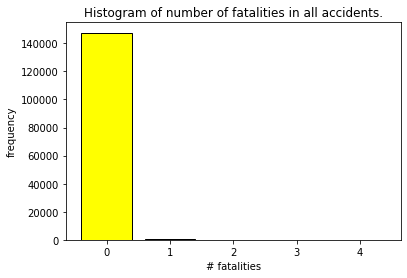

In [7]:
plt.hist(data_raw['fatal_count'], bins=[0, 1, 2, 3, 4, 5], edgecolor='black', rwidth=.8, color='yellow', align='left')
plt.xticks = [1, 2, 3, 4]
plt.title("Histogram of number of fatalities in all accidents.")
plt.xlabel("# fatalities")
plt.ylabel("frequency")
plt.show()

<br><br>
<font size="4" />Then I took a closer look at the accidents with fatalities - most had only one.

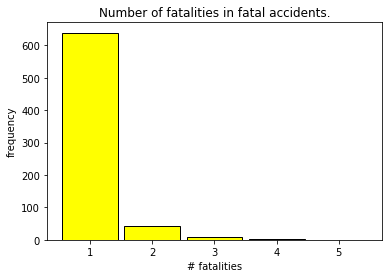

In [8]:
plt.figure()
plt.hist(data_raw[data_raw['fatal_count'] > 0]['fatal_count'], bins=[1, 2, 3, 4, 5, 6], edgecolor='black', rwidth=.9,
         color='yellow', align='left')
plt.title("Number of fatalities in fatal accidents.")
plt.xlabel("# fatalities")
plt.ylabel("frequency")
plt.show()

<br>
<font size="4" />It seemed likely that time of day and month might be important predictors of fatalities, but both are usually coded as either magnitudes or categories. Neither seemed right to me - the former is inaccurate and represents, e.g. 24:00 and 01:00, as maximally dissimilar when they are adjacent hours, whereas the latter jetisons similarity altogether. The function below codes times (represented as 1 through 24 in the dataset) and months as coordinates on a circle, preserving similarity between all adjacent times and months. Probably doesn't do much in the end, but it could linearize some problems if the targets are clustered together at the end and beginning of the cycles.



In [9]:
# convert the month and day to x,y coordinates of a circle and add them into the data frame
xmonth, ymonth, month = time_to_circlexy(data_raw['datetime'], 'month')
xhour, yhour = time_to_circlexy(data_raw['hour'], 'hour')

# add the transformed time units to the dataframe
data = data_raw.copy()
data['xhour'] = xhour
data['yhour'] = yhour
data['xmonth'] = xmonth
data['ymonth'] = ymonth

<br>
<font size="4" />The goal of this analysis was to predict which crashes were fatal, not how many died. So I created a variable where any number of fatalities is set to 1. The variable "fatal_count" will be dropped.

In [10]:
wasfatal = data['fatal_count'].copy()
wasfatal[wasfatal > 0] = 1
data['wasfatal'] = wasfatal

<font size="4" />I then explored the data, trying to figure out if there was actually any hope of predicting fatal crashes. These descriptive plots take a look at whether various features predict the percentage of crashes for given feature values. There seems to be a reasonable amount of structure in the data. The pecentage of fatal crashes varies quite a bit depending on time of day, weather, road conditions, and lighting. (I didn't know the exact meaning of some of these variables - for instance I don't know what "road condition 5" means - presumably "slippery", but the point is that they are predictive). Interestingly, there were slightly more crashes in the spring/summer months than the winter months, possibly because of more drinking during those months. Also interestingly, speed limit doesn't seem to matter, giving a highly insignficant chisquare value.

[47.64425322] [5.11018175e-12]
[0.00424018] [0.94808113]
[55.88378082] [7.68842389e-14]
[5.86380991] [0.0154553]
[56.64500519] [5.22032848e-14]
[326.55986288] [5.39592063e-73]


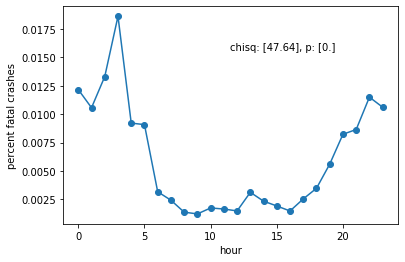

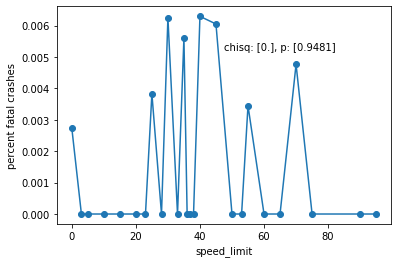

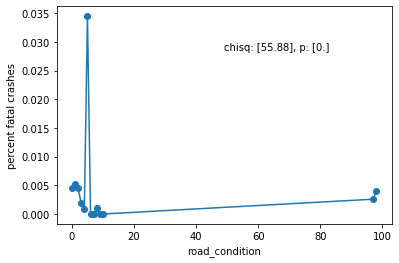

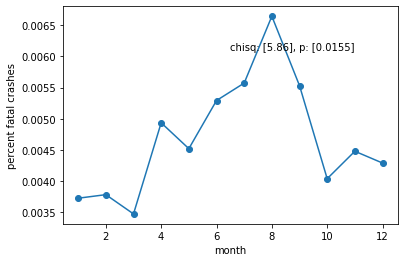

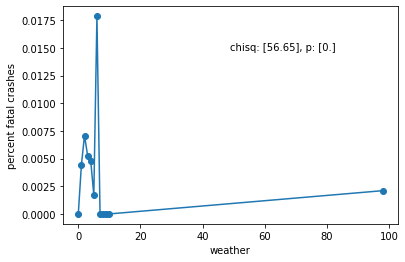

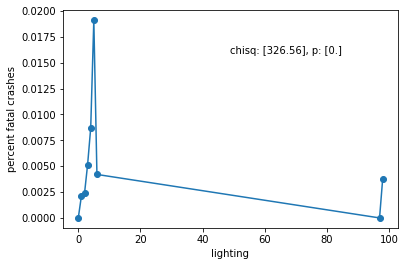

In [11]:
def plotfatalityrates(mydata, colname):
    junk = pd.DataFrame()
    junk[colname] = mydata[colname].values
    junk['wasfatal'] = mydata['wasfatal'].values
    statsdata = pd.DataFrame(junk).dropna()

    stats, p = chi2(statsdata[colname].to_numpy().reshape(-1, 1), statsdata['wasfatal'].to_numpy().reshape(-1, 1))

    plt.figure()
    plt.plot(mydata.groupby(['%s' % colname]).mean()['wasfatal'], 'o-')
    plt.ylabel('percent fatal crashes')
    plt.xlabel('%s' % colname)
    plt.annotate(f"chisq: {np.round(stats, 2)}, p: {np.round(p, 4)}", xy=(.5, .8), xycoords='axes fraction')

    print(stats, p)


featlist = ['hour', 'speed_limit', 'road_condition', 'month', 'weather', 'lighting']
datatmp = data.copy()
datatmp['month'] = month

for f in featlist:
    plotfatalityrates(datatmp, f)


<font size="4" />Drop the variables in droplist. Also drop a random street name that ended up in the "alcohol" column somehow (took a while to find that - argh!).

In [12]:
dummies = pd.get_dummies(data[dummylist].astype('category'))
data = pd.concat([data, dummies], axis=1, join='inner')

data_trunc = data.drop(droplist, axis=1).dropna()
data_trunc['alcohol'][data_trunc['alcohol'] == 'WOODWARD'] = 0
data_trunc['weather'][data_trunc['weather'] == 98] = 11

# Data scaling:

<font size="4" />For most features I'll just subtract the mean and divide by standard dev, but I'm not sure if that is appropriate for latitude and longitude. To make sure I preserved the space represented by lat and lon, I scaled them by their maximums (latitude -90 to 90, longitude -180 to 180) instead of their standard deviation.

In [13]:
data_trunc['X'] = data_trunc['X'] / 180
data_trunc['Y'] = data_trunc['Y'] / 90

<font size="4" />Now I'll scale all of the variables that are not between 1 and -1, mostly count and scale variables (see scalelist above). I used StandardScaler here, so it is demeaned and divided by the standard deviation. I might consider using MinMaxScaler next time so all the variables are between zero and one.

In [14]:
scaler = StandardScaler()
data_scaled = data_trunc.copy()
data_scaled[scalelist] = scaler.fit_transform(data_trunc[scalelist])

<font size="4" />Now that everything is ready, I'll take out the "was_fatal" column and make it the separate label df.

In [15]:
y = data_scaled['wasfatal'].copy()
X = data_scaled.drop(['wasfatal'], axis=1)

# Visualizing

<font size="4" />I did a PCA to get a sense of how the fata accidents are distributed in the feature space.

In [16]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
# pca.components_ is n_components by n_features, so here I label the columns by the features
comp = pd.DataFrame(pca.components_, columns=pd.DataFrame(X).columns)

<font size="4" />These plots show which features load on the PCs. Each line is a PC, the x-axis shows the original features, and the y-axis shows how much each feature loads on the components. You should be able to see the entire plot by first double clicking on it, then scrolling to the right using the bar under the figure. So, for instance, PC1 (orange) is related to lighting, road conditions, and weather. It's really a fun way to interpret the PCs.

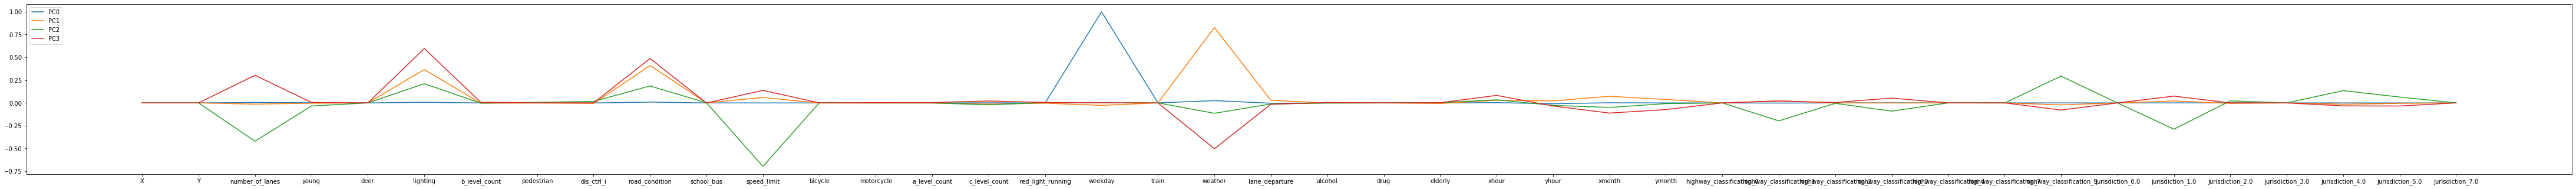

In [17]:
plt.close()
fig = plt.figure()
axes = fig.add_axes([0, 0, 10, 1])
plt.plot(comp.iloc[0, :], label='PC0')
plt.plot(comp.iloc[1, :], label='PC1')
plt.plot(comp.iloc[2, :], label='PC2')
plt.plot(comp.iloc[3, :], label='PC3')
plt.legend(loc="upper left")
plt.show()

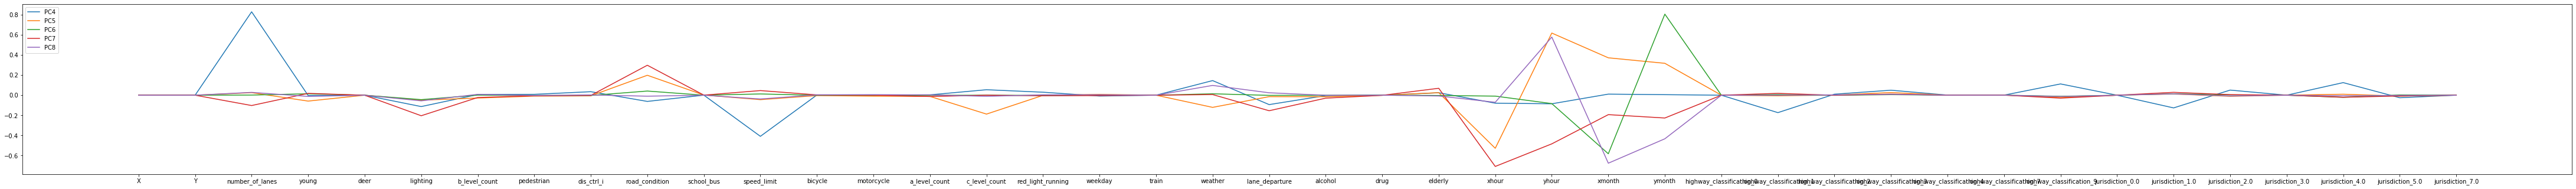

In [18]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 10, 1])
plt.plot(comp.iloc[4, :], label='PC4')
plt.plot(comp.iloc[5, :], label='PC5')
plt.plot(comp.iloc[6, :], label='PC6')
plt.plot(comp.iloc[7, :], label='PC7')
plt.plot(comp.iloc[8, :], label='PC8')
plt.legend(loc="upper left")
plt.show()

<font size="4" />These plots show where the fatal accidents (red dots) are in feature space relative to the non-fatal accidents (blue dots). I won't go into detail about each plot, but in many of the plots below, you can see that the fatal accidents form coherent clusters in the space. Because there are so many dots, the fatal dots tended to get occluded by the non-fatal dots. So, I plotted the fatal dots on top of the non-fatal dots.

<font size="4" />It's important to keep in mind that, under all of the red dots is a dense group of blue dots - thus the fatal and non-fatal accidents are intermixed even in parts of the space where the probability of fatal accidents is highest.

<font size="4" />The first component is actually the days of the week and does not appear to be predictive at all. The second component (y-axis) is much more predictive.

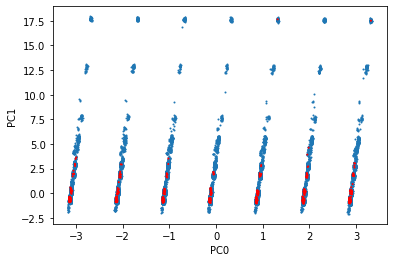

In [19]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='red', s=y)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

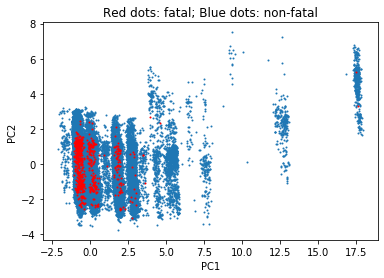

In [20]:
plt.scatter(X_pca[:, 1][y == 0], X_pca[:, 2][y == 0], s=1)
plt.scatter(X_pca[:, 1][y == 1], X_pca[:, 2][y == 1], c='red', s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Red dots: fatal; Blue dots: non-fatal')
plt.show()

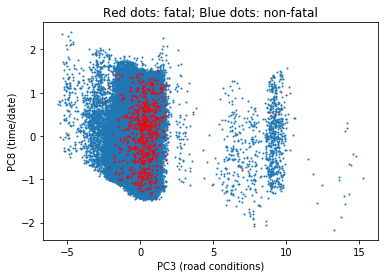

In [21]:
plt.scatter(X_pca[:, 3][y == 0], X_pca[:, 8][y == 0], s=1)
plt.scatter(X_pca[:, 3][y == 1], X_pca[:, 8][y == 1], c='red', s=1)
plt.xlabel('PC3 (road conditions)')
plt.ylabel('PC8 (time/date)')
plt.title('Red dots: fatal; Blue dots: non-fatal')
plt.show()

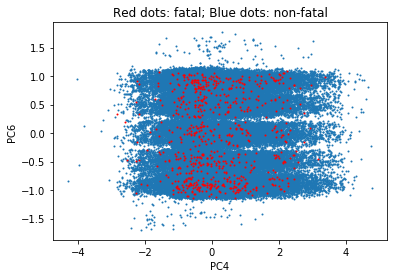

In [22]:
plt.scatter(X_pca[:, 4][y == 0], X_pca[:, 6][y == 0], s=1)
plt.scatter(X_pca[:, 4][y == 1], X_pca[:, 6][y == 1], c='red', s=1)
plt.xlabel('PC4')
plt.ylabel('PC6')
plt.title('Red dots: fatal; Blue dots: non-fatal')
plt.show()

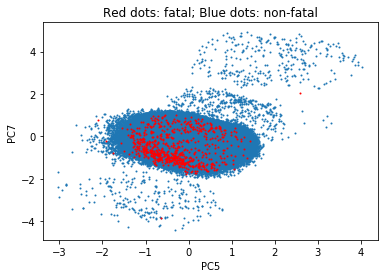

In [23]:
plt.scatter(X_pca[:, 5][y == 0], X_pca[:, 7][y == 0], s=1)
plt.scatter(X_pca[:, 5][y == 1], X_pca[:, 7][y == 1], c='red', s=1)
plt.xlabel('PC5')
plt.ylabel('PC7')
plt.title('Red dots: fatal; Blue dots: non-fatal')
plt.show()

# Analysis
<br>
<font size="4" />In this section I do the fun part - trying to get various machine learning algorithms to efficiently predict fatal accidents. I used logistic regression, SVM with rbf kernel, and the gradient boosted decision trees.  Each model is evaluated on several metrics: recall at 90% accuracy, recall at threshold .5, precision at threshold .5, and area under the precision/recall curve.

<font size="4" />First we slip the data into training and test...

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.33, stratify=y, random_state=0)

In [25]:
# uncomment and run to load the processed data without running the cells above:

X_train, X_test, y_train, y_test = loadprocessdata()

<font size="4" />For all the model fitting, I took the approach of first fitting the model and choosing which parameters yielded the best recall using GridSearchCV (GridSearchCV has the very nice property of being able to use multiple cores, allowing me to take advantage of my 16-core PC). After trying a few different cross validation strategies, I settled on 30 randomly selected stratified folds, testing a third of the data each time. This gave a good balance between speed and consistent results, but there was some evidence below that some noise was introduced by this cross validation procedure. In future exercises with very skewed datasets like this one, I would probably double or even triple the number of folds - for now I decided not to let the perfect be the enemy of the good. Once I had a set of parameters, I plotted recall, precision, f1, and accuracy against the a series of probability thresholds. I found that the best thresholds were always quite low, so I'm showing a very low range in the plots in most cases.

<font size="4" />For the first exercise, I went with Logistic Regression, fitting a wide range of C values from .01 (a lot of regularlization) to 1000 (very little regularization) and penalty (l1 vs. l2).

In [26]:
# thresholds to sample
thresh = np.linspace(.001, .01, num=20)

In [27]:
tuned_parameters = [{'C': [.01, .1, 10, 50, 100, 1000], 'penalty': ['l1', 'l2']}]

# lreg1_avpr = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000,random_state=fold_ind, penalty='l2'),
#                    tuned_parameters, scoring='recall', cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True)

lreg1_avpr = GridSearchCV(LogisticRegression(solver='saga', max_iter=2000, random_state=0),
                          tuned_parameters, scoring='average_precision',
                          cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12,
                          return_train_score=True)
lreg1_avpr.fit(X_train, y_train)


# save the classifier
dumpandloadclf('dump', lreg1_avpr, 'lreg1_avpr')

<font size=4>The first two rows of the summary below report the best parameters - in this case the parameters that resulted in the best average precision. The best reported parameters were C = 10 and 'l2' regularization - although it looks like C 10 through 1000 were all the same to three significant digits and the penalties were also the same within that range (columns under "Grid scores...). (Note that the first of the two tables shows the scores for the validation set. I also plotted the training set grid scores under that to help assess bias and variance). Notice also that, at the default threshold of .5, the model didn't do well be any measure other than accuracy, as shown on the last table (Last table, called "Detailed classification report", second row, starting with "1", meaning metrics for targets). Precision: .46, recall: .03, f1: .05. That might not be surprising, given how intermixed the targets (fatalities) were with non-targets, but, as we will see, other models actually did much better.

In [28]:
summarize_gridsearch('lreg1_avpr', X_test, y_test)
# <font size=4>Our goal was to get recall up as high as possible while maintaining high accuracy by adjusting the threshold. The plot below shows the precision, recall, accuracy, and F1 plotted against probability thresholds between .002 and .01 - see the table after the two figures for the actual numbers. As one might expect, recall continued to improve with lower thresholds. Accuracy remained pretty high up to .006, but started to drop more sharply after that. The model achieved a recall of .74 while maintaining an accuracy of 90% - better than I explected actually. So, it was able to detect 74% of the targets while still rejecting the vast majority of the non-targets. Just what we would want in that kind of warning system.

Best parameters set found on development set:

{'C': 10, 'penalty': 'l2'}

Grid scores on development set (validation):

0.044 (+/-0.046) for {'C': 0.01, 'penalty': 'l1'}
0.076 (+/-0.029) for {'C': 0.01, 'penalty': 'l2'}
0.145 (+/-0.044) for {'C': 0.1, 'penalty': 'l1'}
0.133 (+/-0.042) for {'C': 0.1, 'penalty': 'l2'}
0.149 (+/-0.047) for {'C': 10, 'penalty': 'l1'}
0.149 (+/-0.047) for {'C': 10, 'penalty': 'l2'}
0.149 (+/-0.047) for {'C': 50, 'penalty': 'l1'}
0.149 (+/-0.047) for {'C': 50, 'penalty': 'l2'}
0.149 (+/-0.047) for {'C': 100, 'penalty': 'l1'}
0.149 (+/-0.047) for {'C': 100, 'penalty': 'l2'}
0.149 (+/-0.047) for {'C': 1000, 'penalty': 'l1'}
0.149 (+/-0.047) for {'C': 1000, 'penalty': 'l2'}

Grid scores on development set (train):

0.044 (+/-0.045) for {'C': 0.01, 'penalty': 'l1'}
0.079 (+/-0.016) for {'C': 0.01, 'penalty': 'l2'}
0.148 (+/-0.030) for {'C': 0.1, 'penalty': 'l1'}
0.139 (+/-0.027) for {'C': 0.1, 'penalty': 'l2'}
0.160 (+/-0.030) for {'C': 10, 'penalty': 'l1'}
0.1

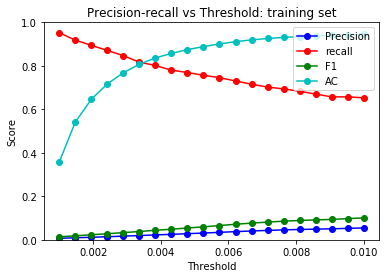

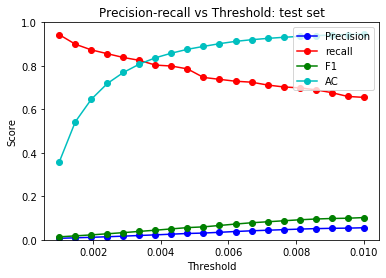

Scores for the test set:

precision  recall   ac    f1    threshold  
0.007      0.943  0.358   0.014   0.001  
0.009      0.900  0.543   0.018   0.001  
0.011      0.873  0.646   0.023   0.002  
0.014      0.856  0.719   0.028   0.002  
0.017      0.838  0.769   0.033   0.003  
0.020      0.825  0.808   0.039   0.003  
0.023      0.803  0.837   0.044   0.004  
0.026      0.799  0.858   0.050   0.004  
0.029      0.786  0.876   0.056   0.005  
0.031      0.747  0.889   0.059   0.005  
0.034      0.738  0.902   0.066   0.006  
0.038      0.729  0.913   0.072   0.006  
0.041      0.725  0.920   0.078   0.007  
0.044      0.712  0.926   0.083   0.007  
0.047      0.703  0.931   0.087   0.008  
0.049      0.699  0.935   0.092   0.008  
0.051      0.690  0.939   0.096   0.009  
0.053      0.677  0.942   0.098   0.009  
0.054      0.659  0.944   0.099   0.010  
0.055      0.655  0.946   0.102   0.010  


In [29]:
# dictionary of scores used for the entire project
arrayinit = np.zeros([len(thresh)])

scoredict = {
    'ac': {'datasets': {'training': arrayinit.copy(), 'test': arrayinit.copy()}, 'scoretype': accuracy_score},
    'prec': {'datasets': {'training': arrayinit.copy(), 'test': arrayinit.copy()}, 'scoretype': precision_score},
    'rec': {'datasets': {'training': arrayinit.copy(), 'test': arrayinit.copy()}, 'scoretype': recall_score},
    'f1': {'datasets': {'training': arrayinit.copy(), 'test': arrayinit.copy()}, 'scoretype': f1_score}
}
summarize_threshold_scores('lreg1_avpr', scoredict, thresh, X_train, y_train, X_test, y_test)


<font size="4" />For each model, I'm keeping track of the recall, precision, area under the precision recall curve, and the model's recall at 90% accuracy. The bar plot below shows the four scores for the logistic linear regression model. <b>These metrics are for performance on the full test set with the model trained on the full training set, using the best parameters for the average of the validation sets.</b> 

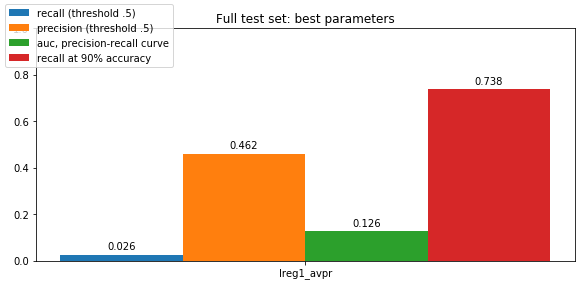

In [30]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr')

<font size="4" />...and finally, the roc curve and precision-recall curve so the models can be compared.

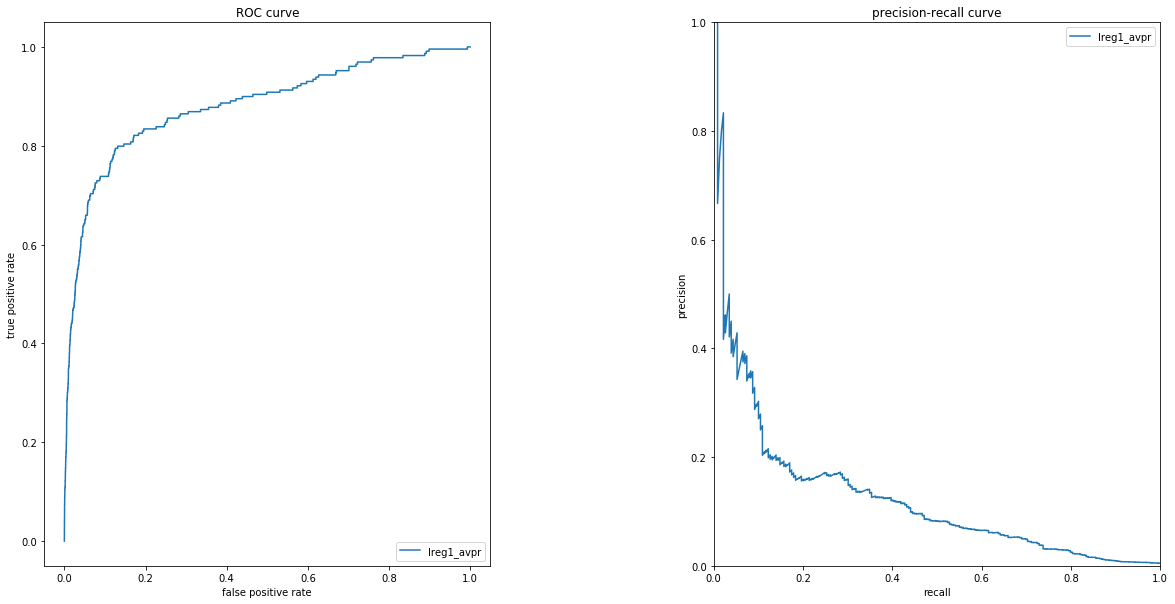

In [31]:
plotrocs(X_test, y_test, 0, "lreg1_avpr")

<br>
<br>
<br>
<br>

# Thesholding a support vector machine with rbf kernel

<font size="4" />The PCA seemed to suggest that the fatal accidents were distributed in multiple discrete clusters within the feature space rather than being linearly separable, so it seemed like an instance based approach might perform well. I therefore tried an SVM with rbf kernel. As before, I used grid search to find the best hyperparameters (gamma and C in this case) and then find the best threshold. I learned a lot from doing this. The SVM was very fiddly and I spent a lot of time off-camera trying to find the correct range for my grid search. The rbf kernel was also very slow to fit, even when I set GridSearchCV to use 12 cores at once. Next time I do this, I will use kernel estimation and a linear SVM to speed things up.

<font size="4" />I searched within gamma = [.3, .2, .1, .05, .01] and C = [10,20,30,50], again evaluating on average precision. 

In [32]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



tuned_parameters = [{'gamma': [.3, .2, .1, .05, .01],
                     'C': [10, 20, 30, 50]}]

# lreg1_avpr = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000,random_state=fold_ind, penalty='l2'),
#                    tuned_parameters, scoring='recall', cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True)

svmrbf_avpr = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=0),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
svmrbf_avpr.fit(X_train, y_train)

# save the classifier
dumpandloadclf('dump', svmrbf_avpr, 'svmrbf_avpr')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  5.146261278192202


<font size="4" />The best model got a precision of 0.42, recall 0.07, F1 0.13, and auc .145 for the test set - fairly similar to the logistic regression model. The threshold plots, however are much worse than the logistic regression: at 90% accuracy, recall is only about 50%.

<font size="4" />The threshold plots are shown after the classification report.

Best parameters set found on development set:

{'C': 30, 'gamma': 0.05}

Grid scores on development set (validation):

0.096 (+/-0.035) for {'C': 10, 'gamma': 0.3}
0.135 (+/-0.044) for {'C': 10, 'gamma': 0.2}
0.185 (+/-0.053) for {'C': 10, 'gamma': 0.1}
0.180 (+/-0.055) for {'C': 10, 'gamma': 0.05}
0.168 (+/-0.069) for {'C': 10, 'gamma': 0.01}
0.081 (+/-0.030) for {'C': 20, 'gamma': 0.3}
0.116 (+/-0.042) for {'C': 20, 'gamma': 0.2}
0.172 (+/-0.049) for {'C': 20, 'gamma': 0.1}
0.188 (+/-0.055) for {'C': 20, 'gamma': 0.05}
0.168 (+/-0.069) for {'C': 20, 'gamma': 0.01}
0.074 (+/-0.027) for {'C': 30, 'gamma': 0.3}
0.107 (+/-0.040) for {'C': 30, 'gamma': 0.2}
0.158 (+/-0.048) for {'C': 30, 'gamma': 0.1}
0.189 (+/-0.056) for {'C': 30, 'gamma': 0.05}
0.170 (+/-0.068) for {'C': 30, 'gamma': 0.01}
0.069 (+/-0.027) for {'C': 50, 'gamma': 0.3}
0.096 (+/-0.039) for {'C': 50, 'gamma': 0.2}
0.142 (+/-0.047) for {'C': 50, 'gamma': 0.1}
0.185 (+/-0.050) for {'C': 50, 'gamma': 0.05}
0.175 (+/-0.065) fo

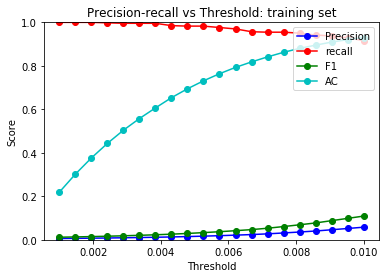

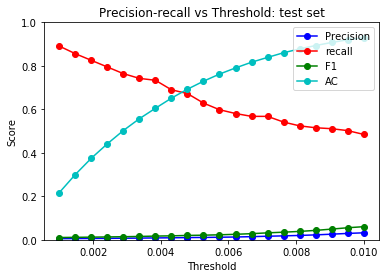

Scores for the test set:

precision  recall   ac    f1    threshold  
0.005      0.891  0.217   0.011   0.001  
0.006      0.856  0.300   0.011   0.001  
0.006      0.825  0.375   0.012   0.002  
0.007      0.795  0.442   0.013   0.002  
0.007      0.764  0.503   0.014   0.003  
0.008      0.742  0.557   0.015   0.003  
0.009      0.734  0.605   0.017   0.004  
0.009      0.690  0.651   0.018   0.004  
0.010      0.672  0.693   0.020   0.005  
0.011      0.629  0.729   0.021   0.005  
0.012      0.598  0.762   0.023   0.006  
0.013      0.581  0.790   0.025   0.006  
0.014      0.568  0.817   0.028   0.007  
0.016      0.568  0.839   0.032   0.007  
0.018      0.541  0.860   0.035   0.008  
0.020      0.524  0.878   0.039   0.008  
0.023      0.515  0.893   0.043   0.009  
0.026      0.511  0.907   0.049   0.009  
0.029      0.502  0.920   0.055   0.010  
0.032      0.485  0.929   0.060   0.010  


In [33]:
summarize_gridsearch('svmrbf_avpr', X_test, y_test)
summarize_threshold_scores('svmrbf_avpr', scoredict, thresh, X_train, y_train, X_test, y_test)

In [ ]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr')
# <font size="4" />The first two models are somewhat similar on most evaluation metrics, but the comparison between the precision-recall curves (second figure) is interesting. The svm is better at lower recall rates and the regression is better at higher recall rates, consistent with its better recall performance at high accuracies. This highlights that standard metrics, like area under the curve, might not always be useful for specific goals. It is also interesting to compare the ROC curve (left) to the precision-recall curve (right). If you just look at the ROC, you would think that the logistic regression was unambiguously better, but the measure hides nuances in this skewed dataset - i.e. the svm performs better at low recall rates.
#     
# <font size="4" />Because both optimal hyperparameters were within the search's range, I stopped here, although things might still be improved by testing nearby values.

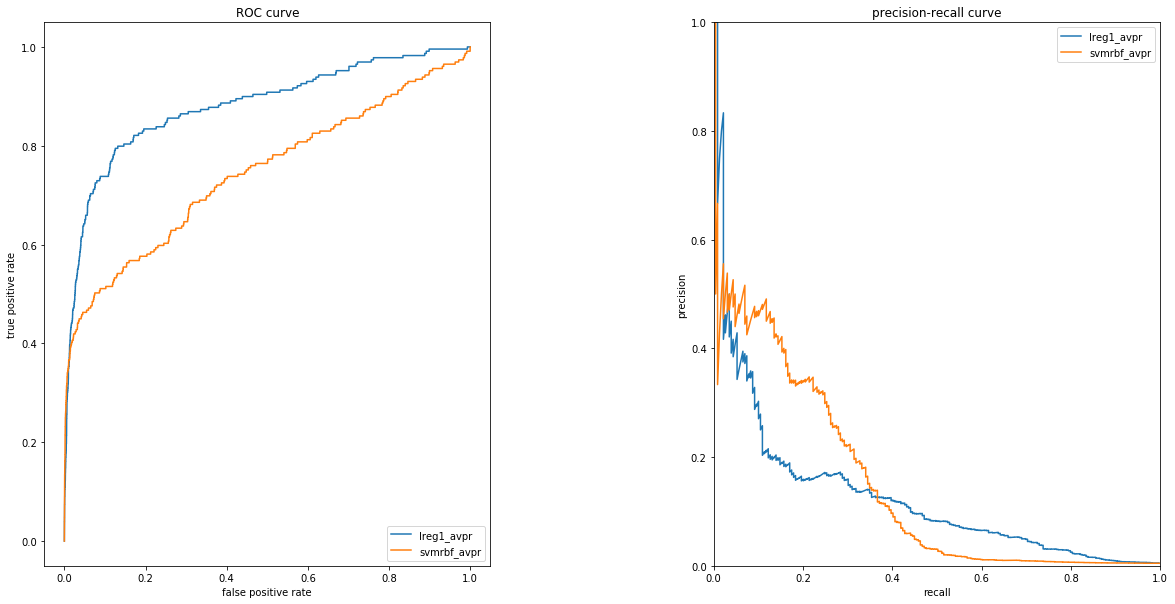

In [35]:
plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr")

# Gradient boosted decision tree

<font size="4" />The final classifier I tried was a GradientBoostingClassifier. This classifier has a very large number of parameters related to the decision trees and the number of boosting iterations, so this parameter search was more involved. The order of hyperparameter fitting and many of the ranges, was largely taken from here https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/.
    
<font size="4" />The first parameter I fit was n_estimators, the number of boosting iterations. I tried 40 through 70 in steps of 10. The other parameters were set at educated guesses:
    
learning_rate=0.1<br>
min_samples_split=1400 (.5 to 1 percent of total values)<br>
min_samples_leaf=50<br>
max_depth=8<br>
max_features='sqrt'<br>
subsample=0.8<br>
<br>
<font size="4" />Again, the search settled on a value within the search range: n_estimators = 60.

In [36]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)

tuned_parameters = [{'n_estimators': range(40, 70, 10)}]

gbc_avpr = GridSearchCV(
    GradientBoostingClassifier(learning_rate=0.1, min_samples_split=1400, min_samples_leaf=50, max_depth=8,
                               max_features='sqrt', subsample=0.8, random_state=0),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr, 'gbc_avpr')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.01056984908050961


In [ ]:
summarize_gridsearch('gbc_avpr', X_test, y_test)
summarize_threshold_scores('gbc_avpr', scoredict, thresh, X_train, y_train, X_test, y_test)
# <br>
# <br>
# <font size="4" />The bar plot and precision-recall curves show that while the model was similar to the previous models on some metrics, the auc was a bit better. Also, it achieved a recall of 80% at 90% accuracy, an improvement over both models. Again, this is reflected in high-recall portion of the precision-recall curve (green line, leftmost part of the figure). 

<br>
<br>
<font size="4" />Interestingly, the initial model is worse than the SVM on precision and recall at threshold .5 (blue and orange bars), but already out-performs it on the metrics we care about: area under the precision recall curve and recall at the threshold that gives 90% accuracy.

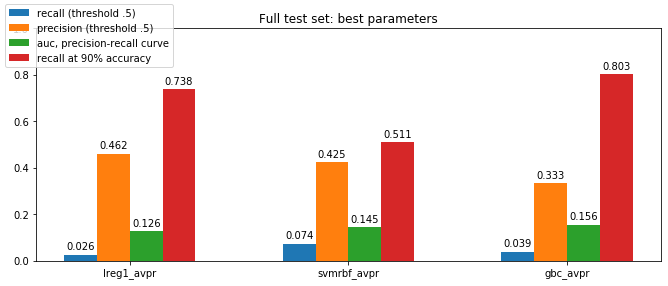

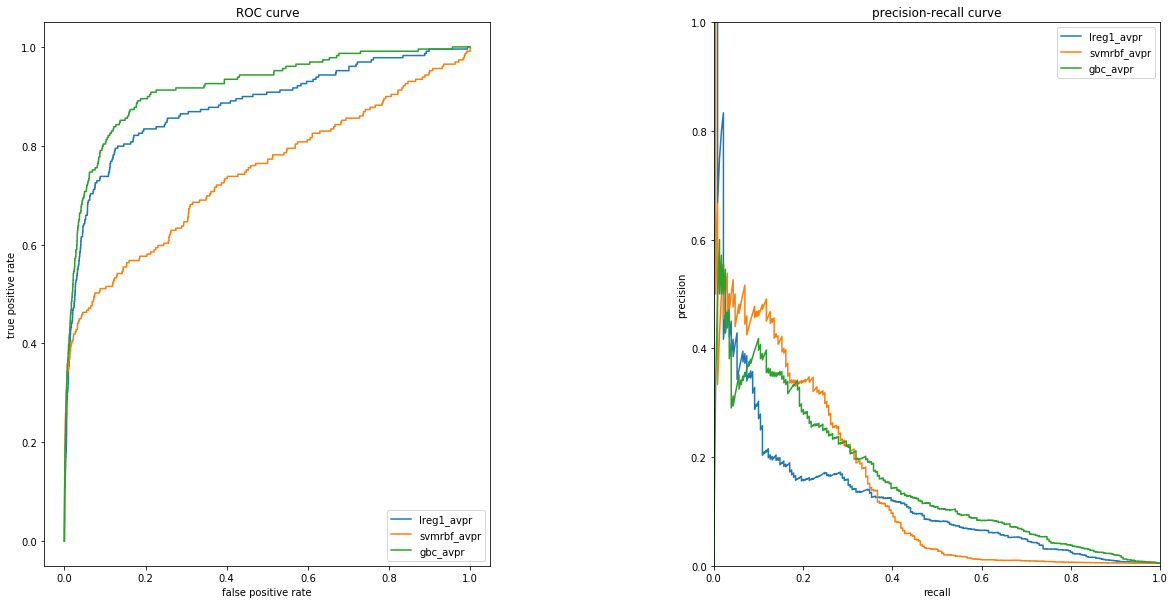

In [38]:
# note: this function sometimes gives a "RuntimeWarning: invalid value encountered in true_divide"
# I couldn't quite figure out the source of this error, but all the values look right, so I let it alone
# It is true that, at some thresholds, some cells of the confusion matrix contain 0, so the warnings could come from
# calculating the auc for precision-recall
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr', 'gbc_avpr')
plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr", "gbc_avpr")

<font size="4" />For the next step, I fit max_depth (the maximum number of times the tree is allowed another iteration of branching) and min_samples_split (the minimum number of samples a branch can have before being allowed to split it into new branches). The number of estimators was set to the best parameters for the previous model (60).

In [39]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



# this retrieves all the fit models from disk and puts them into a library 
# so their parameters can be retrieved even if the kernel has been restarted
clfdict = loadsomeclfs("")
n_est = clfdict['gbc_avpr'].best_params_['n_estimators']
clfdict.clear()
tuned_parameters = [{'max_depth': range(4, 16, 2), 'min_samples_split': [500, 1000, 1400, 2000]}]

gbc_avpr2 = GridSearchCV(
    GradientBoostingClassifier(n_estimators=n_est, learning_rate=0.1, min_samples_leaf=50, max_features='sqrt',
                               subsample=0.8, random_state=0),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr2.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr2, 'gbc_avpr2')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.09131213784217834


<font size="4" />The best max_depth, 14, was in the search range, but the best min_samples_split was at the highest value, 2000. On the full test set, the best parameters improved both precision and area under the precision-recall curve over earlier versions of the model (gbc_avpr2), as one would expect if the grid search was actually identifying better parameters. Results are shown in the next bar graph. 
    


Best parameters set found on development set:

{'max_depth': 14, 'min_samples_split': 2000}

Grid scores on development set (validation):

0.191 (+/-0.067) for {'max_depth': 4, 'min_samples_split': 500}
0.190 (+/-0.060) for {'max_depth': 4, 'min_samples_split': 1000}
0.173 (+/-0.048) for {'max_depth': 4, 'min_samples_split': 1400}
0.172 (+/-0.050) for {'max_depth': 4, 'min_samples_split': 2000}
0.220 (+/-0.081) for {'max_depth': 6, 'min_samples_split': 500}
0.214 (+/-0.073) for {'max_depth': 6, 'min_samples_split': 1000}
0.216 (+/-0.079) for {'max_depth': 6, 'min_samples_split': 1400}
0.215 (+/-0.072) for {'max_depth': 6, 'min_samples_split': 2000}
0.237 (+/-0.072) for {'max_depth': 8, 'min_samples_split': 500}
0.223 (+/-0.076) for {'max_depth': 8, 'min_samples_split': 1000}
0.230 (+/-0.075) for {'max_depth': 8, 'min_samples_split': 1400}
0.237 (+/-0.075) for {'max_depth': 8, 'min_samples_split': 2000}
0.235 (+/-0.076) for {'max_depth': 10, 'min_samples_split': 500}
0.228 (+/-0.072) fo

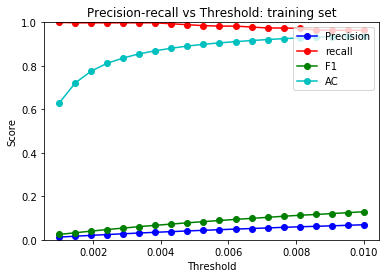

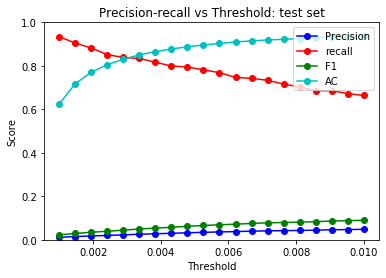

Scores for the test set:

precision  recall   ac    f1    threshold  
0.012      0.934  0.626   0.023   0.001  
0.015      0.904  0.718   0.029   0.001  
0.018      0.882  0.771   0.035   0.002  
0.020      0.852  0.805   0.039   0.002  
0.023      0.838  0.831   0.044   0.003  
0.026      0.834  0.850   0.050   0.003  
0.028      0.817  0.866   0.054   0.004  
0.030      0.799  0.877   0.058   0.004  
0.032      0.795  0.888   0.062   0.005  
0.034      0.782  0.896   0.066   0.005  
0.036      0.769  0.903   0.069   0.006  
0.038      0.747  0.910   0.072   0.006  
0.040      0.742  0.915   0.075   0.007  
0.041      0.734  0.919   0.078   0.007  
0.042      0.716  0.922   0.079   0.008  
0.043      0.703  0.926   0.081   0.008  
0.044      0.686  0.929   0.083   0.009  
0.046      0.686  0.932   0.086   0.009  
0.047      0.672  0.935   0.088   0.010  
0.048      0.664  0.937   0.090   0.010  


In [40]:
summarize_gridsearch('gbc_avpr2', X_test, y_test)
summarize_threshold_scores('gbc_avpr2', scoredict, thresh, X_train, y_train, X_test, y_test)


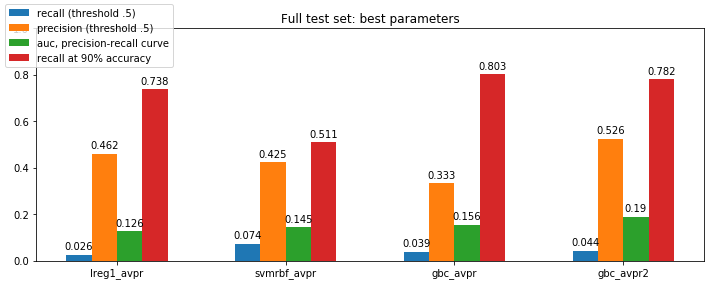

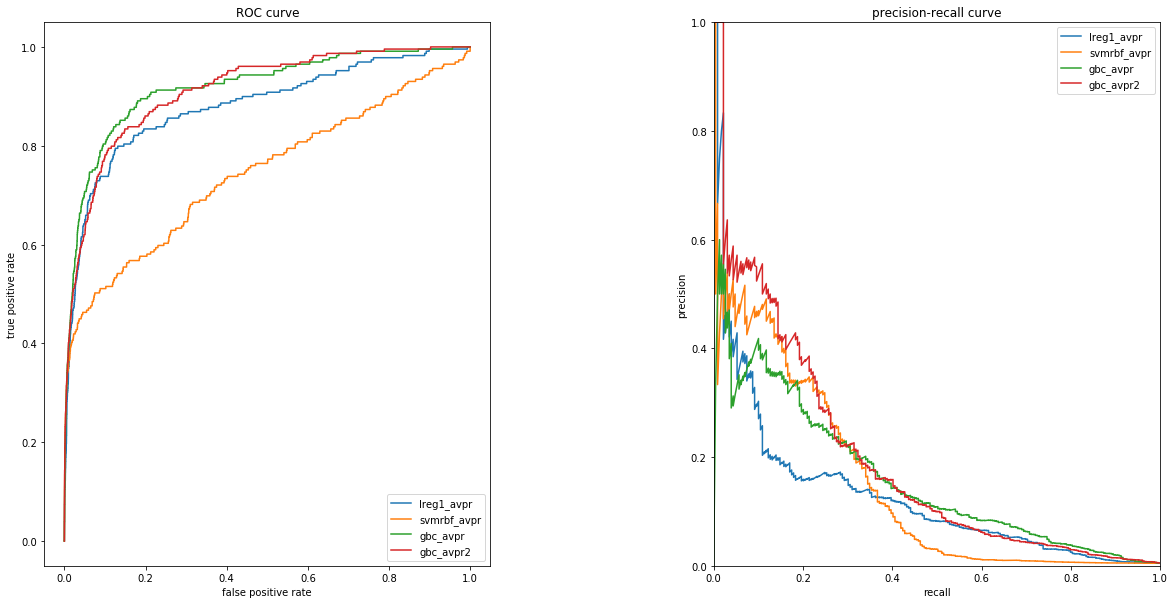

In [41]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr', 'gbc_avpr', 'gbc_avpr2')

plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr",
               "gbc_avpr", "gbc_avpr2")


<font size="4" />Because min_samples_split was at the top edge of the search range, I did a second iteration, holding max_depth at 14. The grid search below identified 2500 as the best value for min_samples_split. It was within the search range, allowing us to move on. The search range was fairly large, so it might have been possible to find an even better value.

In [42]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



clfdict = loadsomeclfs("")
n_est = clfdict['gbc_avpr'].best_params_['n_estimators']
clfdict.clear()
tuned_parameters = [{'max_depth': [14], 'min_samples_split': [2000,2500,3000]}]

gbc_avpr2b = GridSearchCV(
    GradientBoostingClassifier(n_estimators=n_est, learning_rate=0.1, min_samples_leaf=50, max_features='sqrt',
                               subsample=0.8, random_state=10),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr2b.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr2b, 'gbc_avpr2b')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.016477893789609274


Best parameters set found on development set:

{'max_depth': 14, 'min_samples_split': 2500}

Grid scores on development set (validation):

0.212 (+/-0.095) for {'max_depth': 14, 'min_samples_split': 2000}
0.219 (+/-0.085) for {'max_depth': 14, 'min_samples_split': 2500}
0.215 (+/-0.084) for {'max_depth': 14, 'min_samples_split': 3000}

Grid scores on development set (train):

0.535 (+/-0.089) for {'max_depth': 14, 'min_samples_split': 2000}
0.501 (+/-0.091) for {'max_depth': 14, 'min_samples_split': 2500}
0.460 (+/-0.090) for {'max_depth': 14, 'min_samples_split': 3000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48680
           1       0.51      0.08      0.14       229

    accuracy                           1.00     48909
   macro avg       0.75      0.54      0.57     48909
weighted avg  

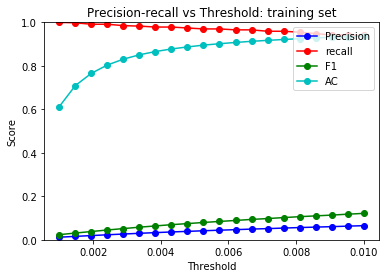

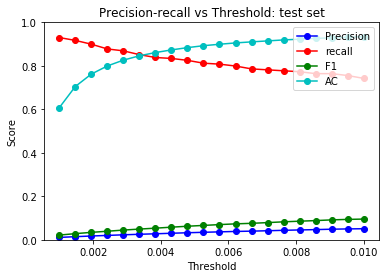

Scores for the test set:

precision  recall   ac    f1    threshold  
0.011      0.930  0.608   0.022   0.001  
0.014      0.917  0.705   0.028   0.001  
0.017      0.900  0.762   0.034   0.002  
0.020      0.878  0.800   0.039   0.002  
0.023      0.869  0.826   0.045   0.003  
0.025      0.852  0.846   0.049   0.003  
0.028      0.838  0.861   0.054   0.004  
0.030      0.834  0.873   0.058   0.004  
0.032      0.825  0.884   0.062   0.005  
0.034      0.812  0.893   0.066   0.005  
0.037      0.808  0.899   0.070   0.006  
0.038      0.799  0.905   0.073   0.006  
0.040      0.786  0.910   0.076   0.007  
0.042      0.782  0.915   0.079   0.007  
0.044      0.777  0.919   0.083   0.008  
0.045      0.773  0.923   0.086   0.008  
0.047      0.764  0.926   0.088   0.009  
0.049      0.764  0.929   0.092   0.009  
0.050      0.755  0.932   0.094   0.010  
0.051      0.742  0.934   0.095   0.010  


In [43]:
summarize_gridsearch('gbc_avpr2b', X_test, y_test)
summarize_threshold_scores('gbc_avpr2b', scoredict, thresh, X_train, y_train, X_test, y_test)

<font size="4" />Whereas some of the metrics decreased slightly (final bar group, "gbc_avpr2b"), the values were similar to the previous model. To avoid fitting the test set, I kept the current set of parameters rather than the previous set, which got slightly better scores. This choice is discussed further at the end of the notebook.

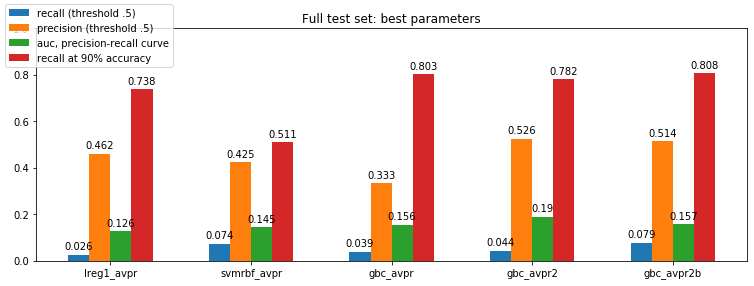

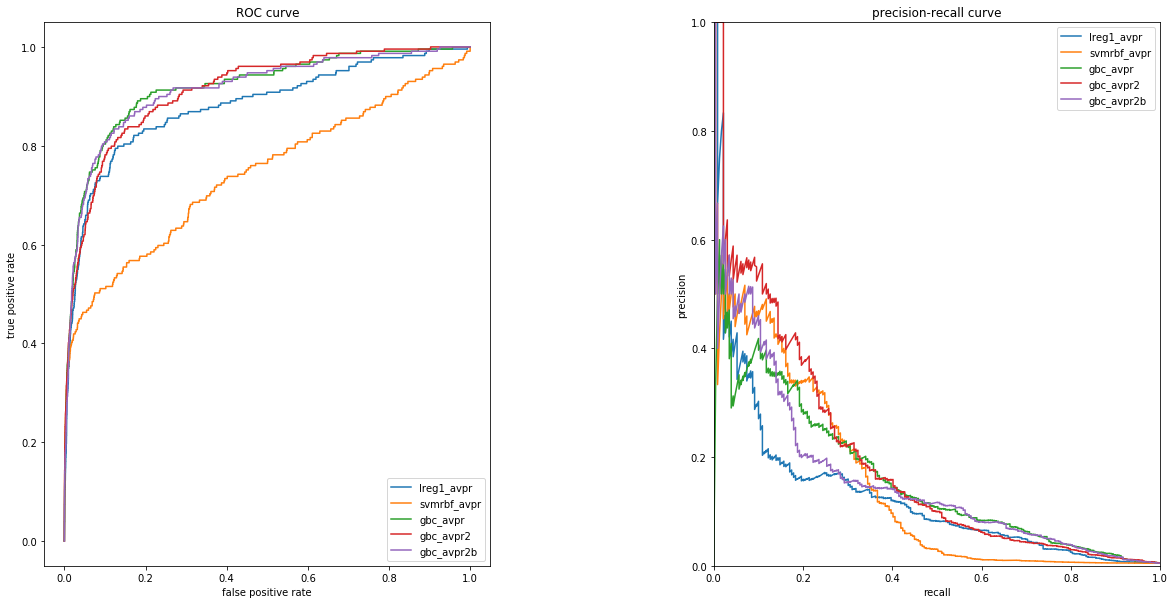

In [44]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr', 'gbc_avpr', 'gbc_avpr2',
                       'gbc_avpr2b')

plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr",
               "gbc_avpr", "gbc_avpr2", "gbc_avpr2b")


<font size="4" />Ok, now it's time to fit min_samples_leaf and max_features (the maximum number of features fit for each tree). 

In [45]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



clfdict = loadsomeclfs("")
n_est = clfdict['gbc_avpr'].best_params_['n_estimators']
max_d = clfdict['gbc_avpr2b'].best_params_['max_depth']
minssplit = clfdict['gbc_avpr2b'].best_params_['min_samples_split']
clfdict.clear()

tuned_parameters = [{'min_samples_leaf': [10, 20, 30, 50, 70, 90], 'max_features': ['sqrt', 6, 8, 10]}]

gbc_avpr3 = GridSearchCV(
    GradientBoostingClassifier(n_estimators=n_est, min_samples_split=minssplit, max_depth=max_d, learning_rate=0.1,
                               subsample=0.8, random_state=10),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr3.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr3, 'gbc_avpr3')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.13388330936431886


<font size="4" />Best values for both parameters fell at the edge of the search range, so I extended the search in the next iteration.

Best parameters set found on development set:

{'max_features': 10, 'min_samples_leaf': 90}

Grid scores on development set (validation):

0.179 (+/-0.071) for {'max_features': 'sqrt', 'min_samples_leaf': 10}
0.204 (+/-0.084) for {'max_features': 'sqrt', 'min_samples_leaf': 20}
0.202 (+/-0.082) for {'max_features': 'sqrt', 'min_samples_leaf': 30}
0.219 (+/-0.085) for {'max_features': 'sqrt', 'min_samples_leaf': 50}
0.219 (+/-0.087) for {'max_features': 'sqrt', 'min_samples_leaf': 70}
0.237 (+/-0.091) for {'max_features': 'sqrt', 'min_samples_leaf': 90}
0.179 (+/-0.071) for {'max_features': 6, 'min_samples_leaf': 10}
0.204 (+/-0.084) for {'max_features': 6, 'min_samples_leaf': 20}
0.202 (+/-0.082) for {'max_features': 6, 'min_samples_leaf': 30}
0.219 (+/-0.085) for {'max_features': 6, 'min_samples_leaf': 50}
0.219 (+/-0.087) for {'max_features': 6, 'min_samples_leaf': 70}
0.237 (+/-0.091) for {'max_features': 6, 'min_samples_leaf': 90}
0.187 (+/-0.094) for {'max_features': 8, 'min_sampl

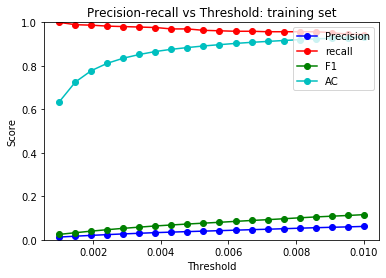

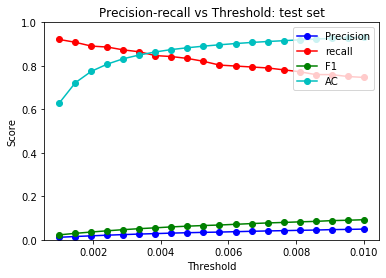

Scores for the test set:

precision  recall   ac    f1    threshold  
0.012      0.921  0.629   0.023   0.001  
0.015      0.908  0.722   0.030   0.001  
0.018      0.891  0.775   0.036   0.002  
0.021      0.886  0.808   0.041   0.002  
0.024      0.873  0.833   0.047   0.003  
0.026      0.865  0.850   0.051   0.003  
0.028      0.847  0.864   0.055   0.004  
0.031      0.843  0.875   0.059   0.004  
0.033      0.834  0.883   0.063   0.005  
0.034      0.821  0.891   0.066   0.005  
0.036      0.803  0.897   0.068   0.006  
0.037      0.799  0.902   0.071   0.006  
0.039      0.795  0.908   0.075   0.007  
0.041      0.790  0.912   0.078   0.007  
0.042      0.782  0.916   0.080   0.008  
0.044      0.773  0.920   0.082   0.008  
0.045      0.760  0.923   0.085   0.009  
0.047      0.760  0.926   0.088   0.009  
0.048      0.751  0.929   0.090   0.010  
0.049      0.747  0.931   0.092   0.010  


In [46]:
summarize_gridsearch('gbc_avpr3', X_test, y_test)
summarize_threshold_scores('gbc_avpr3', scoredict, thresh, X_train, y_train, X_test, y_test)

<font size="4" />All of the metrics were pretty similar to the previous version of the model, although there was some improvement. In the next iteration, I continued the same search beyond the edge of the ranges.

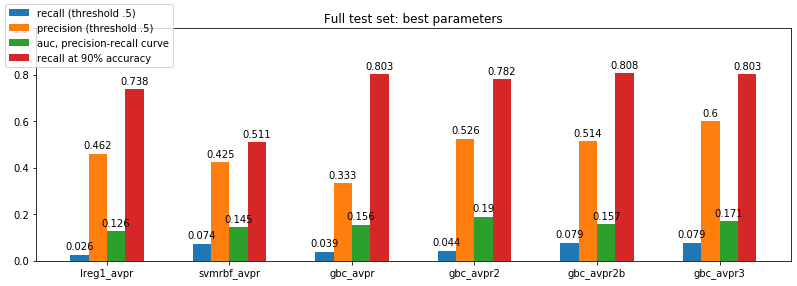

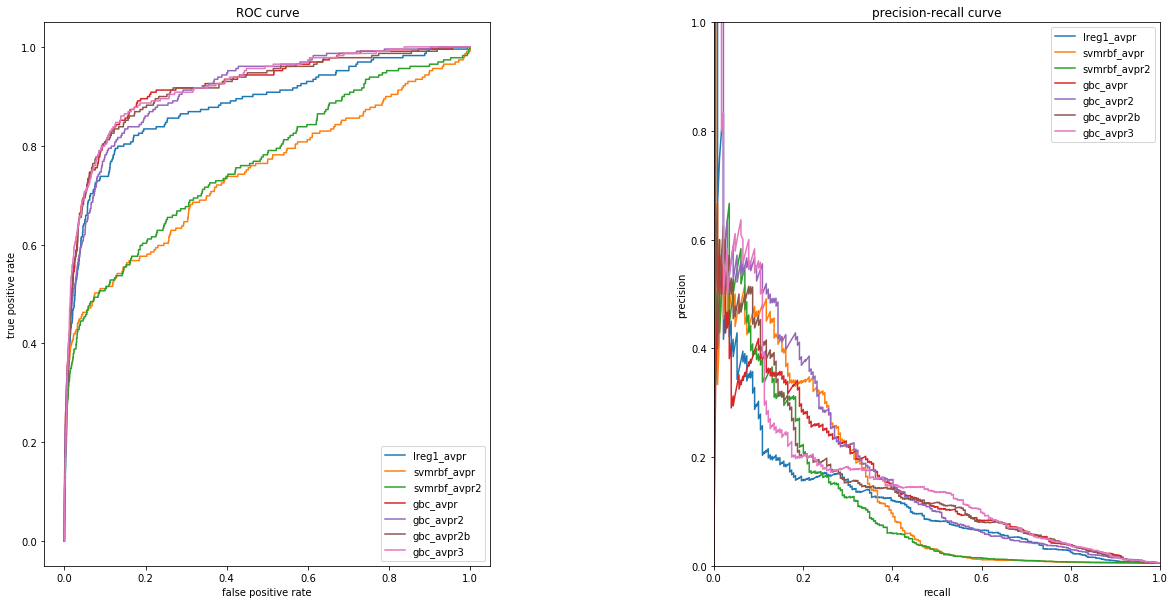

In [47]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr',  'gbc_avpr', 'gbc_avpr2',
                       'gbc_avpr2b', 'gbc_avpr3')

plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr", "svmrbf_avpr2",
              "gbc_avpr", "gbc_avpr2", "gbc_avpr2b", "gbc_avpr3")


<font size="4" />In the iteration below, max_features STILL ended up at the edge of the range, although min samples_leaf settled at 100.

In [48]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



clfdict = loadsomeclfs("")
n_est = clfdict['gbc_avpr'].best_params_['n_estimators']
max_d = clfdict['gbc_avpr2b'].best_params_['max_depth']
minssplit = clfdict['gbc_avpr2b'].best_params_['min_samples_split']
clfdict.clear()

tuned_parameters = [{'min_samples_leaf': [90, 100, 110, 120, 130, 140], 'max_features': [10,12,14,16]}]

gbc_avpr3b = GridSearchCV(
    GradientBoostingClassifier(n_estimators=n_est, min_samples_split=minssplit, max_depth=max_d, learning_rate=0.1,
                               subsample=0.8, random_state=10),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr3b.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr3b, 'gbc_avpr3b')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.193256547053655


Best parameters set found on development set:

{'max_features': 16, 'min_samples_leaf': 100}

Grid scores on development set (validation):

0.242 (+/-0.084) for {'max_features': 10, 'min_samples_leaf': 90}
0.242 (+/-0.087) for {'max_features': 10, 'min_samples_leaf': 100}
0.241 (+/-0.090) for {'max_features': 10, 'min_samples_leaf': 110}
0.239 (+/-0.080) for {'max_features': 10, 'min_samples_leaf': 120}
0.238 (+/-0.083) for {'max_features': 10, 'min_samples_leaf': 130}
0.236 (+/-0.078) for {'max_features': 10, 'min_samples_leaf': 140}
0.238 (+/-0.083) for {'max_features': 12, 'min_samples_leaf': 90}
0.244 (+/-0.087) for {'max_features': 12, 'min_samples_leaf': 100}
0.245 (+/-0.081) for {'max_features': 12, 'min_samples_leaf': 110}
0.244 (+/-0.074) for {'max_features': 12, 'min_samples_leaf': 120}
0.246 (+/-0.072) for {'max_features': 12, 'min_samples_leaf': 130}
0.241 (+/-0.076) for {'max_features': 12, 'min_samples_leaf': 140}
0.237 (+/-0.073) for {'max_features': 14, 'min_samples_lea

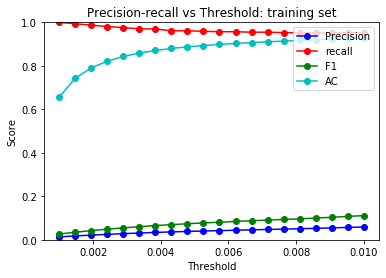

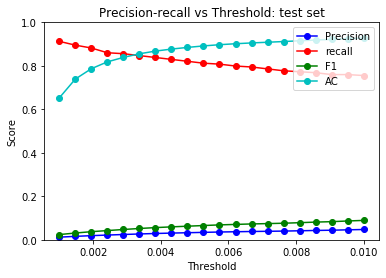

Scores for the test set:

precision  recall   ac    f1    threshold  
0.012      0.913  0.653   0.024   0.001  
0.016      0.895  0.739   0.031   0.001  
0.019      0.882  0.787   0.037   0.002  
0.022      0.860  0.818   0.042   0.002  
0.024      0.856  0.839   0.047   0.003  
0.027      0.847  0.855   0.052   0.003  
0.029      0.838  0.868   0.056   0.004  
0.031      0.830  0.877   0.059   0.004  
0.033      0.821  0.885   0.063   0.005  
0.034      0.812  0.892   0.066   0.005  
0.036      0.808  0.897   0.069   0.006  
0.037      0.799  0.902   0.071   0.006  
0.038      0.795  0.905   0.073   0.007  
0.039      0.786  0.909   0.074   0.007  
0.040      0.777  0.912   0.076   0.008  
0.041      0.773  0.915   0.079   0.008  
0.043      0.769  0.919   0.081   0.009  
0.044      0.760  0.922   0.083   0.009  
0.046      0.760  0.925   0.087   0.010  
0.047      0.755  0.928   0.089   0.010  


In [49]:
summarize_gridsearch('gbc_avpr3b', X_test, y_test)
summarize_threshold_scores('gbc_avpr3b', scoredict, thresh, X_train, y_train, X_test, y_test)

<font size="4" />The bar plot shows that the model is steadily improving as we improve the hyperparameters - precision and area under precision-recall curve are the best yet. Below I continued to increase max_features.

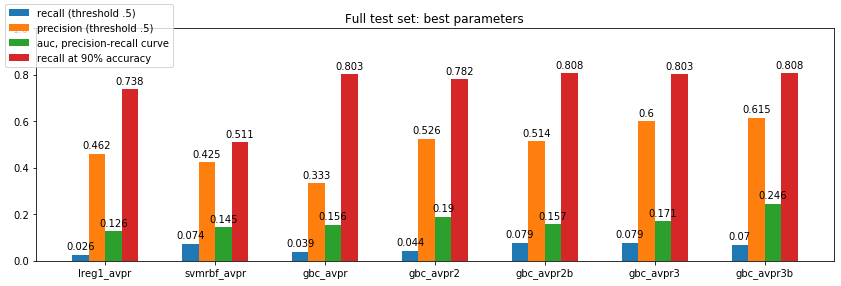

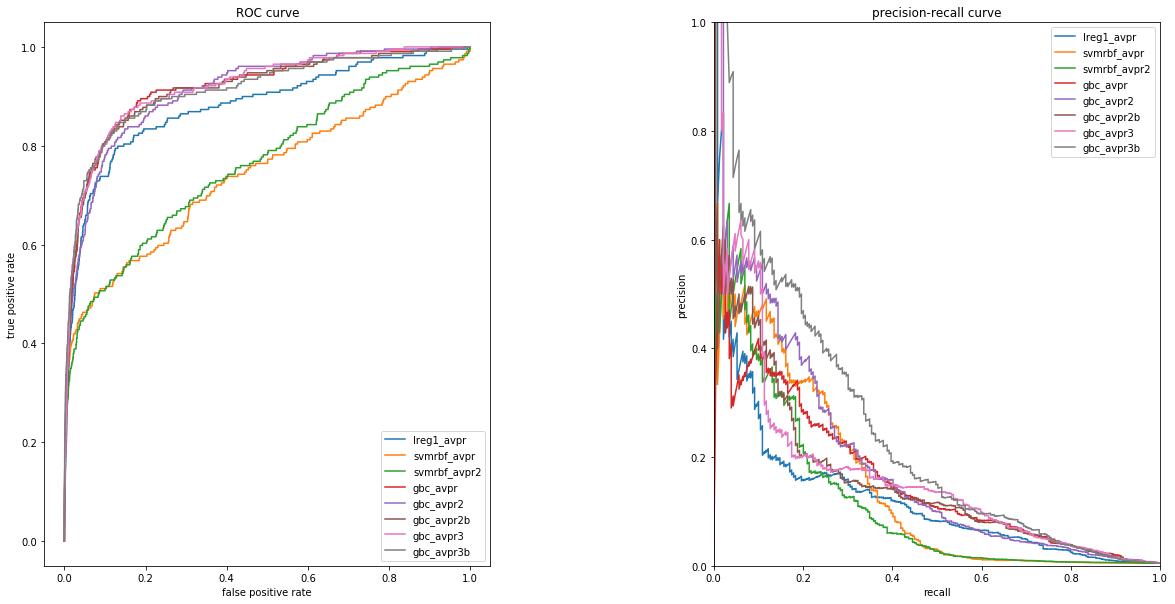

In [50]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr',  'gbc_avpr', 'gbc_avpr2',
                       'gbc_avpr2b', 'gbc_avpr3','gbc_avpr3b')

plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr", "svmrbf_avpr2",
              "gbc_avpr", "gbc_avpr2", "gbc_avpr2b", "gbc_avpr3",'gbc_avpr3b')


<font size="4" />This iteration continued to search for the best max_features value, holding min_samples_leaf at 100. Finally, the best max_features fell within the search range...

In [51]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



clfdict = loadsomeclfs("")
n_est = clfdict['gbc_avpr'].best_params_['n_estimators']
max_d = clfdict['gbc_avpr2b'].best_params_['max_depth']
minssplit = clfdict['gbc_avpr2b'].best_params_['min_samples_split']
clfdict.clear()

tuned_parameters = [{'min_samples_leaf': [100], 'max_features': [16,20,30,40]}]

gbc_avpr3c = GridSearchCV(
    GradientBoostingClassifier(n_estimators=n_est, min_samples_split=minssplit, max_depth=max_d, learning_rate=0.1,
                               subsample=0.8, random_state=10),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr3c.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr3c, 'gbc_avpr3c')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.06566168500317468


Best parameters set found on development set:

{'max_features': 30, 'min_samples_leaf': 100}

Grid scores on development set (validation):

0.252 (+/-0.089) for {'max_features': 16, 'min_samples_leaf': 100}
0.242 (+/-0.075) for {'max_features': 20, 'min_samples_leaf': 100}
0.261 (+/-0.084) for {'max_features': 30, 'min_samples_leaf': 100}
0.251 (+/-0.079) for {'max_features': 40, 'min_samples_leaf': 100}

Grid scores on development set (train):

0.446 (+/-0.052) for {'max_features': 16, 'min_samples_leaf': 100}
0.417 (+/-0.062) for {'max_features': 20, 'min_samples_leaf': 100}
0.440 (+/-0.048) for {'max_features': 30, 'min_samples_leaf': 100}
0.425 (+/-0.037) for {'max_features': 40, 'min_samples_leaf': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48680
           1       1.00      0.01   

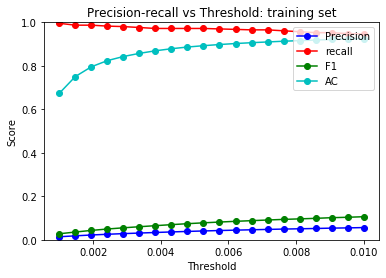

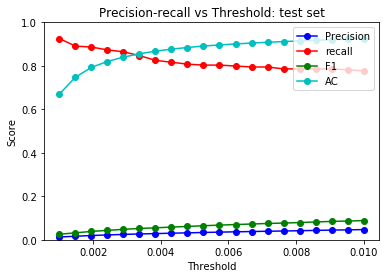

Scores for the test set:

precision  recall   ac    f1    threshold  
0.013      0.926  0.670   0.026   0.001  
0.016      0.891  0.747   0.032   0.001  
0.020      0.886  0.793   0.038   0.002  
0.022      0.873  0.820   0.043   0.002  
0.025      0.865  0.840   0.048   0.003  
0.027      0.847  0.855   0.052   0.003  
0.028      0.825  0.867   0.055   0.004  
0.030      0.817  0.877   0.059   0.004  
0.032      0.808  0.884   0.061   0.005  
0.034      0.803  0.891   0.065   0.005  
0.035      0.803  0.896   0.068   0.006  
0.037      0.799  0.901   0.070   0.006  
0.038      0.795  0.905   0.072   0.007  
0.039      0.795  0.908   0.075   0.007  
0.040      0.786  0.912   0.077   0.008  
0.042      0.786  0.914   0.079   0.008  
0.043      0.786  0.918   0.082   0.009  
0.045      0.786  0.920   0.085   0.009  
0.046      0.782  0.922   0.086   0.010  
0.047      0.777  0.925   0.089   0.010  


In [52]:
summarize_gridsearch('gbc_avpr3c', X_test, y_test)
summarize_threshold_scores('gbc_avpr3c', scoredict, thresh, X_train, y_train, X_test, y_test)

<font size="4" />Ok, this result was a little weird because precision jumped all the way to 1. This suggests that, at a threshold of .5, the model is identifying a very small number of targets. Area under the precision-recall curve was still good and recall at 90% accuracy was also still good at .799, so I stayed with this parameter set.

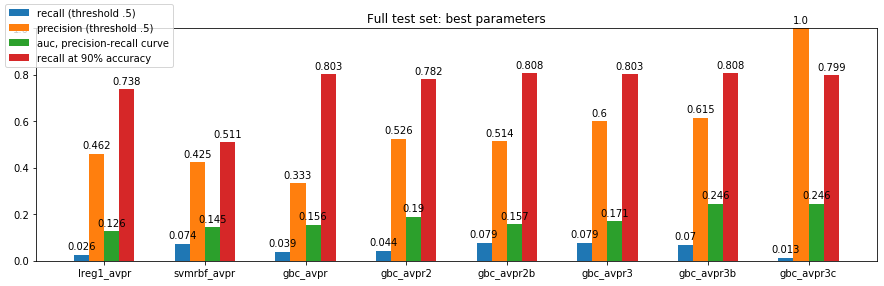

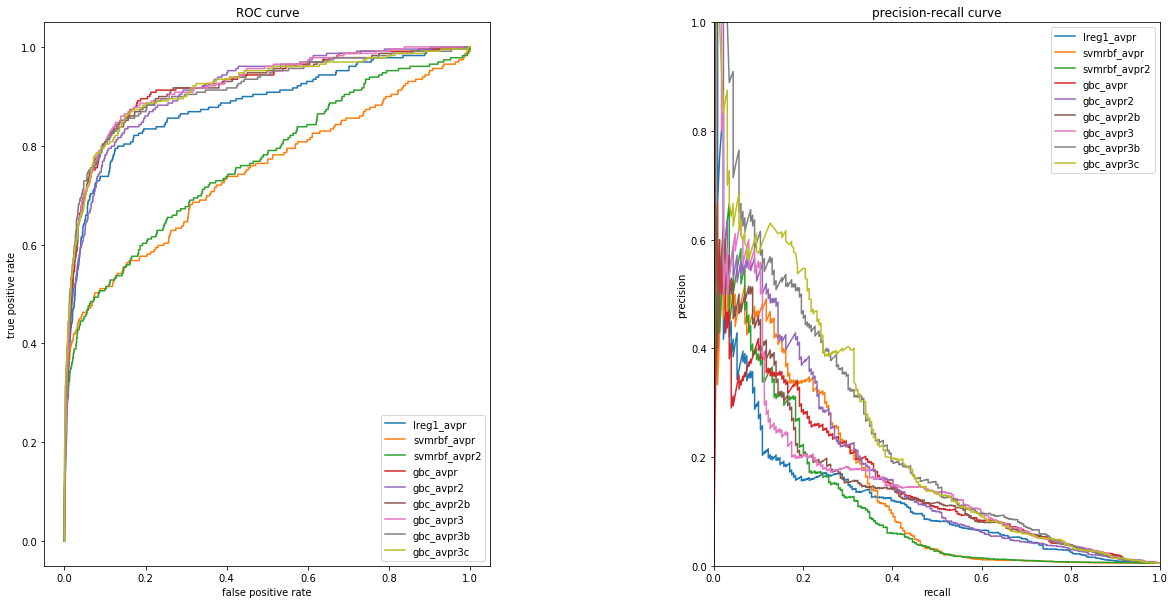

In [53]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr',  'gbc_avpr', 'gbc_avpr2',
                       'gbc_avpr2b', 'gbc_avpr3','gbc_avpr3b','gbc_avpr3c')

plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr", "svmrbf_avpr2",
              "gbc_avpr", "gbc_avpr2", "gbc_avpr2b", "gbc_avpr3",'gbc_avpr3b','gbc_avpr3c')


<font size="4" />For the final stage, I tried lowering the learning rate and raising the number of estimators, again using the best parameters from previous searches....

In [54]:
t = time.time()

thresh = np.linspace(.001, .01, num=20)



# n_est = gbc_avpr.best_params_['n_estimators']
clfdict = loadsomeclfs("")
max_d = clfdict['gbc_avpr2b'].best_params_['max_depth']
minssplit = clfdict['gbc_avpr2b'].best_params_['min_samples_split']
min_samp_leaf = clfdict['gbc_avpr3c'].best_params_['min_samples_leaf']
max_feat = clfdict['gbc_avpr3c'].best_params_['max_features']
# lrn_rate = gbc_avpr4.best_params_['learning_rate']
clfdict.clear()

tuned_parameters = [{'learning_rate': [.001, .01, .05, .1], 'n_estimators': [60, 100, 200, 500]}]

gbc_avpr4 = GridSearchCV(
    GradientBoostingClassifier(min_samples_split=minssplit, max_depth=max_d, min_samples_leaf=min_samp_leaf,
                               max_features=max_feat, subsample=0.8, random_state=10),
    tuned_parameters, scoring='average_precision',
    cv=StratifiedShuffleSplit(n_splits=30, test_size=.33, random_state=0), n_jobs=12, return_train_score=True
)
gbc_avpr4.fit(X_train, y_train)


dumpandloadclf('dump', gbc_avpr4, 'gbc_avpr4')

elapsed = time.time() - t
print('total hours: ', elapsed / 60 / 60)

total hours:  0.9508238537444009


Best parameters set found on development set:

{'learning_rate': 0.05, 'n_estimators': 500}

Grid scores on development set (validation):

0.094 (+/-0.045) for {'learning_rate': 0.001, 'n_estimators': 60}
0.113 (+/-0.048) for {'learning_rate': 0.001, 'n_estimators': 100}
0.125 (+/-0.051) for {'learning_rate': 0.001, 'n_estimators': 200}
0.138 (+/-0.050) for {'learning_rate': 0.001, 'n_estimators': 500}
0.108 (+/-0.049) for {'learning_rate': 0.01, 'n_estimators': 60}
0.132 (+/-0.053) for {'learning_rate': 0.01, 'n_estimators': 100}
0.160 (+/-0.059) for {'learning_rate': 0.01, 'n_estimators': 200}
0.267 (+/-0.089) for {'learning_rate': 0.01, 'n_estimators': 500}
0.197 (+/-0.063) for {'learning_rate': 0.05, 'n_estimators': 60}
0.253 (+/-0.081) for {'learning_rate': 0.05, 'n_estimators': 100}
0.287 (+/-0.088) for {'learning_rate': 0.05, 'n_estimators': 200}
0.302 (+/-0.087) for {'learning_rate': 0.05, 'n_estimators': 500}
0.261 (+/-0.084) for {'learning_rate': 0.1, 'n_estimators': 60}
0.27

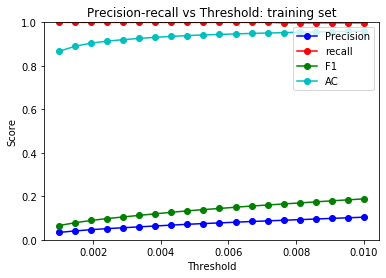

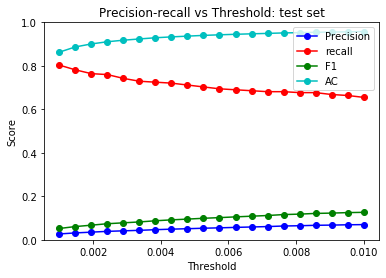

Scores for the test set:

precision  recall   ac    f1    threshold  
0.027      0.803  0.863   0.052   0.001  
0.032      0.782  0.887   0.061   0.001  
0.035      0.764  0.901   0.067   0.002  
0.039      0.760  0.911   0.074   0.002  
0.041      0.742  0.918   0.078   0.003  
0.044      0.729  0.924   0.082   0.003  
0.047      0.725  0.929   0.087   0.004  
0.049      0.721  0.933   0.092   0.004  
0.051      0.712  0.937   0.095   0.005  
0.053      0.703  0.940   0.099   0.005  
0.055      0.694  0.943   0.102   0.006  
0.057      0.690  0.945   0.105   0.006  
0.059      0.686  0.947   0.109   0.007  
0.061      0.681  0.949   0.112   0.007  
0.063      0.681  0.951   0.116   0.008  
0.065      0.677  0.953   0.118   0.008  
0.067      0.677  0.954   0.121   0.009  
0.068      0.668  0.955   0.123   0.009  
0.069      0.664  0.957   0.125   0.010  
0.070      0.655  0.958   0.126   0.010  


In [55]:
summarize_gridsearch('gbc_avpr4', X_test, y_test)
summarize_threshold_scores('gbc_avpr4', scoredict, thresh, X_train, y_train, X_test, y_test)

<font size="4" />The model settled on a learning rate of .5 and 500 estimators. Even though 500 was at the upper edge of the search range, I decided to stop there because of the long time to fit with that many estimators. Precision, recall, and area under precision-recall curve were all improvements over the previous models, but recall at 90% accuracy fell a bit from .8 for the best models to .76. Therefore, if other test sets were available, I might consider trying some of the earlier models against the final model (gbc_avpr4) if I was interested in the on/off warning light application. This result again highlights the need to identify the correct metric for one's goals rather than just use the standard metrics.

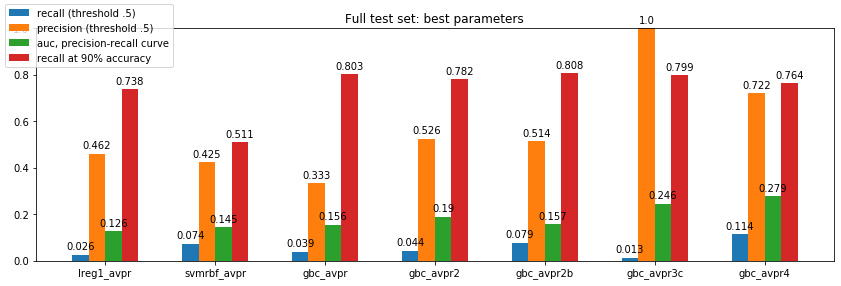

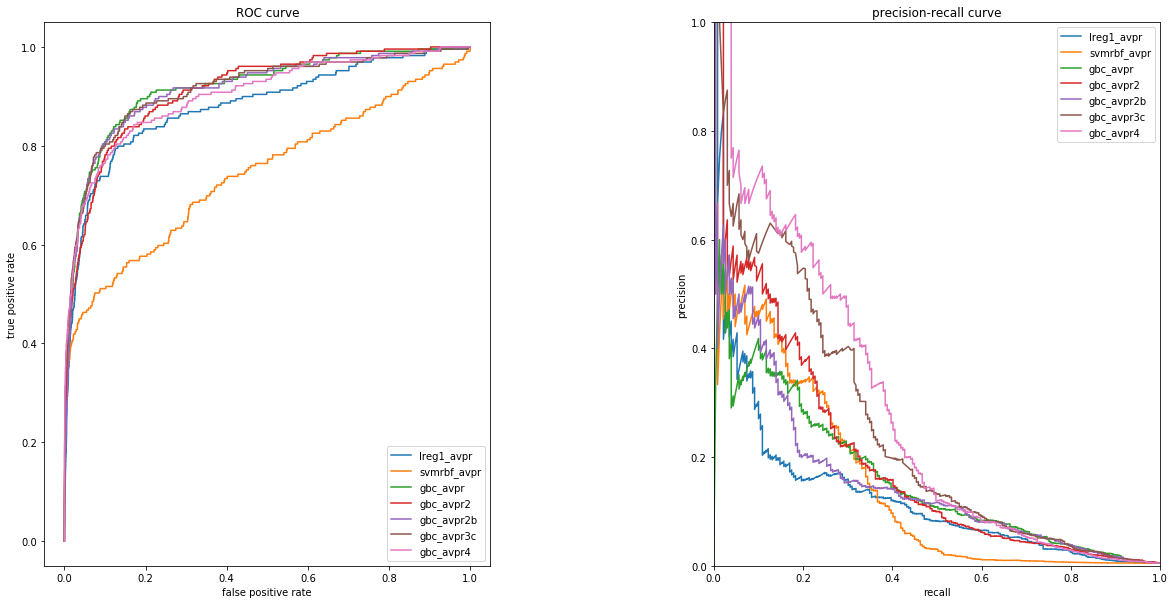

In [56]:
plot_recall_subpl(X_test, y_test, 'lreg1_avpr', 'svmrbf_avpr', 'gbc_avpr',
                       'gbc_avpr2', 'gbc_avpr2b', 'gbc_avpr3c', 'gbc_avpr4')

plotrocs(X_test, y_test, 0, "lreg1_avpr", "svmrbf_avpr",  "gbc_avpr", "gbc_avpr2", "gbc_avpr2b",
              "gbc_avpr3c", "gbc_avpr4")


<font size="4" />Ok, one final fun demo. It was a good exercise to try to classify the fatal accidents, but some warning systems for a car would change color continuously depending on the degree of danger. In other words, it would report the probability of an accident.

<font size="4" />To visualize the probabilities within the space, the standard data science course type thing to do would be to plot a heat map over the entire space (e.g.   https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html), but that is difficult for higher dimensional spaces. I thought it would be interesting to visualize the probability associated with each exemplar instead. Read on below...

<font size="4" />To visualize the exemplar probabilities, I cted the training and test sets into the PCA space then predicted their class probabilities. The data points are sorted so that the highest probability cases are on top and the lower probabilities are layered underneath. The first row of each figure shows the training set and the second row shows the test set. The left-most panel of each row shows the non-target cases, the next panel shows the target cases, and the following panel shows all cases. The final panel is a histogram of the probabilities assigned to the target and non-target cases. To emphasize the spread of probabilities for the target cases, the histograms are "zoomed in" to frequencies of 140 and below, so the bars for the low-probability non-targets (blue bins, furthest to the left of the histogram) go "off the top", since those bins include thousands of cases).
    
<font size="4" />Consider the test set for the final gadient boosted decision tree model (gbc_avpr4, second row). The as can be seen in the histogram and the second column, the fatal test cases are assigned a wide range of probabilities and have more high probabilities than the other models and far fewer low probabilities. The non-fatal cases also have some high probabilites, which is good for our purposes if the are similar to the fatal cases and should trigger a warning or high probability color. The even spread across probabilities would also result in a wide range of colors for our continuous warning light as the driver passed through situations with varying degrees of danger. Overall, it is clear that the gradient boosted decision tree is the best classifier. Some of the GBDT models also had excellent recall at high accuracies, sometimes exceding 80%.
    
<font size="4" />As an interesting side not, the svm assigned very similar probabilities to the vast majority of the positive training cases. The value was intermediate, not at ceiling, so I don't think it was over fitting. I'm not sure why it behaved this way, but I think it might not be the best classifier for this kind of problem.
    
<font size="4" />In the next section, I briefly summarize a grid search using recall as the evaluation metric.

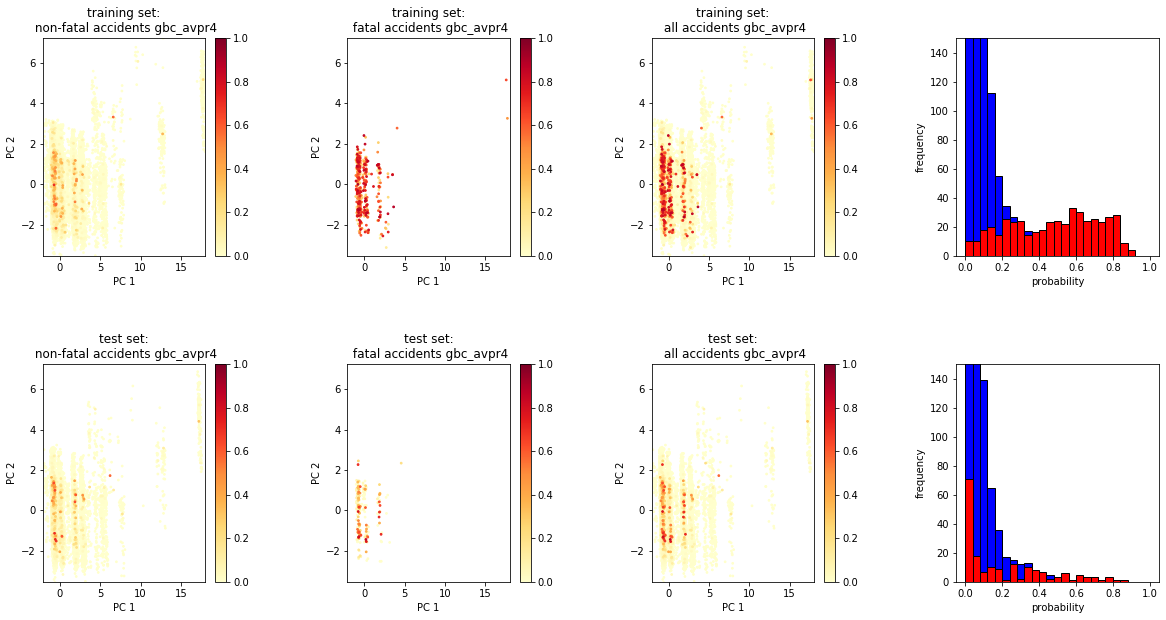

In [57]:
# plotpca_subs23b(classifiername, mysize,mycomps,subpltdim1,subpltdim2)

plotpca_subs23c('gbc_avpr4', 3, [1, 2])

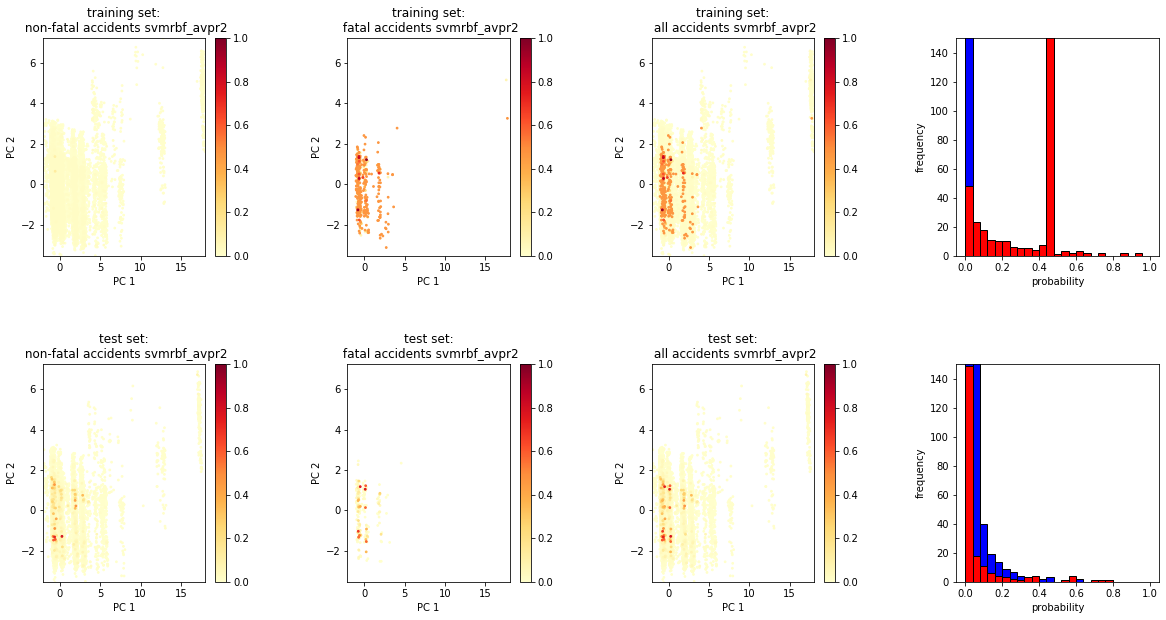

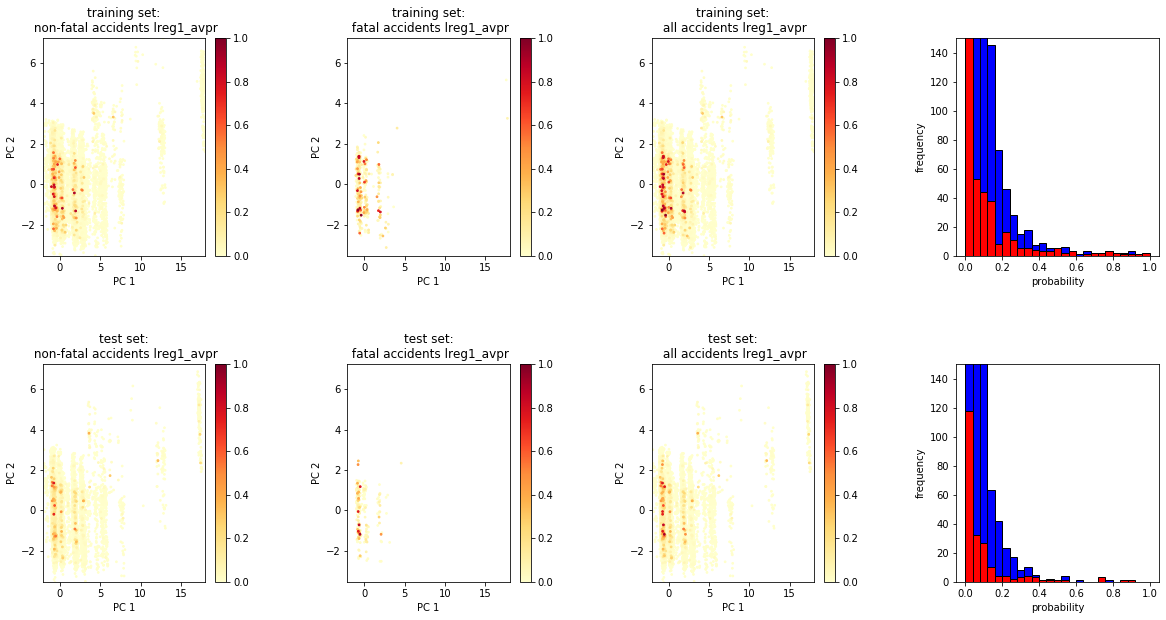

In [58]:
plotpca_subs23c('svmrbf_avpr2', 3, [1, 2])
plotpca_subs23c('lreg1_avpr', 3, [1, 2])

# Grid searches optimizing recall

<font size="4" />In addition to the grid searches above, I conducted searches using recall as the evaluation metric. I did this because one of my goals was to get high recall at high levels of accuracy. The average precision metric takes recall into account and is a good metric for optimizing the precision-recall curve, but this does not necessarily optimize recall at high accuracy thresholds, as we have seen: in the searches above, the final model had worse accuracy at high recalls than earlier versions with less area under the prec-recall curve. The grid searches were conducted in the same way as above, searching through the same parameter ranges, and then extending the ranges if the best parameter was at the edge of the range. Because the code and strategy is essentially the same as above, I decided not to show it in detail and instead summarize the final results.
    
<font size="4" />In the figure below, recall measured with threshold at .5 (blue bars) increased with successive grid searches. This was true for both the SVM (second and third bar groups) and the GBDT (starting at the fourth bar group, labelled "gbc_recall"). This demonstrates that the grid searches were effective. However, hyperparameters that optimized recall did not optimize area under the precision recall curve (green bars) or recall at 90% accuracy (red bars). In fact, both metrics decreased fairly consistently with successive grid search iterations. Optimizing max_features and min_samples_split did improve auc relative to baseline (gbc_recall2 and 2b), but auc decreased consistently after as other hyperparameters were optimized for recall.

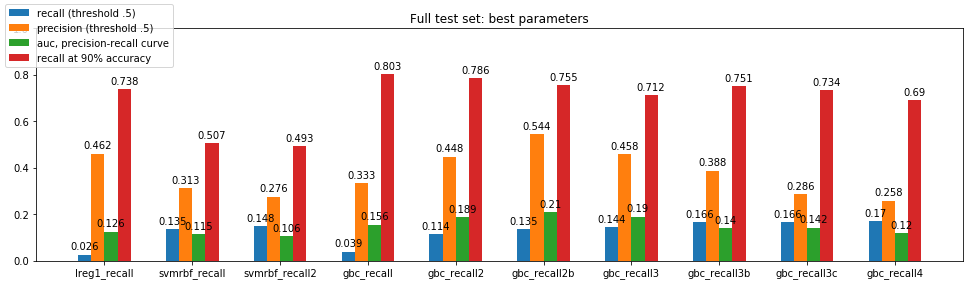

In [59]:
plot_recall_subpl(X_test, y_test, 'lreg1_recall', 'svmrbf_recall', 'svmrbf_recall2', 'gbc_recall',
                       'gbc_recall2', 'gbc_recall2b', 'gbc_recall3', 'gbc_recall3b','gbc_recall3c','gbc_recall4')

In [ ]:
plotrocs(X_test, y_test, 0, 'lreg1_recall', 'svmrbf_recall', 'svmrbf_recall2', 'gbc_recall',
                       'gbc_recall2', 'gbc_recall2b', 'gbc_recall3', 'gbc_recall3b','gbc_recall3c','gbc_recall4')
# <font size="4" />The probability distributions, shown in the scatter plots and histograms below, were fairly similar to the average-precision fit models for the svm and logistic regression, but departed somewhat for the final GBDT, which ended up with a much more bimodal distribution of probabilities when optimized to recall. This can be seen in both the training and testing sets in the first figure below (gbc_recall4). Unlike the average-precision fit model, many targets and non-targes were assigned probabilities of 1.0, resulting in good recall, but worse results on the other metrics.
#
# <font size="4" />In the next, final, section, I compare the best models from the two strategies.

# Comparing recall to average precision models

<font size="4" />Overall, GBDT models out-performed logistic regression and svm on the test set. The bar plot below shows preformance for the two final GBDT models and an intermediate GBDT model optimized for average-precision (middle bar group). For our purposes, the important result is the green bar, showing auc, and the red bar, showing recall at 90% accuracy.  The final average-precision model had the best auc by far (see also the precision-recall curve below) and better recall at high accuracy than the recall-optimized model. But some of the intermediate average-precision models had much better recall at 90% accuracy, breaking 80%. If this were a real product, a good next step would be to see if this difference is consistent or varies a bit depending on the test set. This could be done by getting data from other data sets, or at least doing a second wave of cross validation in which both models are trained on a random two thirds of the data and tested on the remaining third.

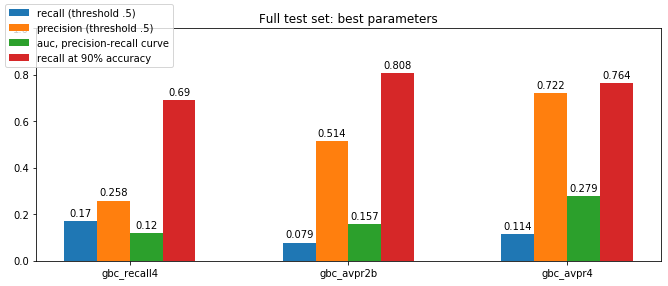

In [61]:
plot_recall_subpl(X_test, y_test,'gbc_recall4', 'gbc_avpr2b','gbc_avpr4')

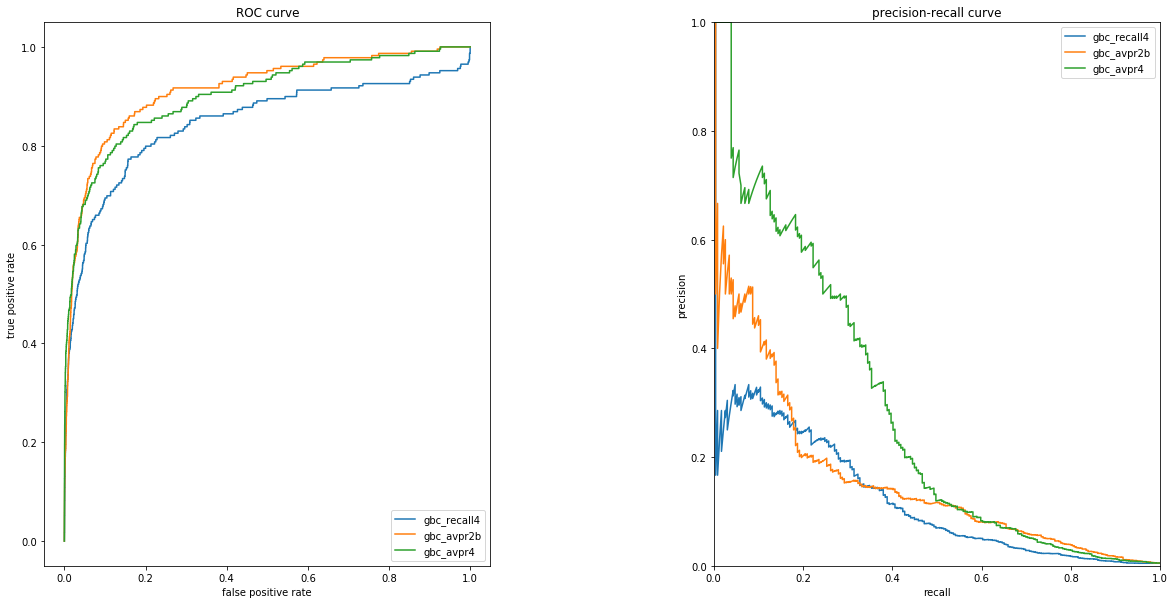

In [62]:
X_train, X_test,y_train,y_test = loadprocessdata()
plotrocs(X_test, y_test, 0, 'gbc_recall4','gbc_avpr2b','gbc_avpr4',)

<font size="4" />...and that concludes this exercise in machine learning.  I certainly learned a lot from it, including some things about python coding and the need to bundle code into functions sooner rather than later. For my next exercise, it would be interesting to make an automated function that performs a series of grid searches according to a fixed set of rules, outputting parameters a performance metrics as it goes.
    
<font size="4" />Another lesson that was hammered home over and over again was that the metric needs to fit the goals of the final task. None of the standard metrics - recall, precision, or area under the precision-recall curve, tracked recall at very high accuracy, which might have been the most important metric for our car warning light. It should be possible to optimize parameters to that metric specifically, but I couldn't find a convenient way to do it and didn't want to take the time to code it by hand for now - one nice thing about GridsearchCV is that it easily allows distribution of jobs across multiple cores, speeding things up considerably.
    
<font size="4" />Of course there are other classifiers that could be fit to these data. I didn't try a random forest or a neural network, for instance, and there is also some pre-processing that could be done on the data, like PCA or ICA. Overall, however, I think the GBDT provided a good intial model for predicting driving situations requiring caution.